In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq
from scipy.optimize import curve_fit

import h5py


# 1. Source Code

In [2]:
def acquire_data(filepath):
    with h5py.File(filepath, "r") as f:
        
        time_units = 2.32515 / 16
        
        times = f['wait_times'][()]
        exp_data = f['Exp_values'][()]
        ff_gain = f['gainVec'][()]
        
    times *= time_units
    
    return times, exp_data, ff_gain

In [3]:
def acquire_singleshot_data(filepath, readout_qubit):
    
    readout_number = readout_qubit[1]
    
    with h5py.File(filepath, "r") as f:
        
        time_units = 2.32515 / 16
        
        i_g = f[f'i_g{readout_number}'][()]
        q_g = f[f'q_g{readout_number}'][()]
        
        i_e = f[f'i_e{readout_number}'][()]
        q_e = f[f'q_e{readout_number}'][()]
        
        angle = f['angle'][()][0]
        threshold = f['threshold'][()][0]
        
        return i_g, q_g, i_e, q_e, angle, threshold

In [4]:
def generate_singleshot_filename(year, month, day, hour, minute, second, local=False):
    date_code = f'{year}_{month}_{day}'
    time_code = f'{hour}_{minute}_{second}'
    if local:
        return r'C:\Users\mattm\OneDrive\Desktop\Research\Measurements\4Q_Test_Scalinq\SingleShot\SingleShot_{}\SingleShot_{}_{}_data.h5'.format(date_code, date_code, time_code)
    else:
        return r'V:\QSimMeasurements\Measurements\4Q_Test_Scalinq\SingleShot\SingleShot_{}\SingleShot_{}_{}_data.h5'.format(date_code, date_code, time_code)

In [5]:
def generate_swaps_filename(year, month, day, hour, minute, second, adiabatic=False):
    date_code = f'{year}_{month}_{day}'
    time_code = f'{hour}_{minute}_{second}'
    if adiabatic:
        return r'V:\QSimMeasurements\Measurements\4Q_Test_Scalinq\AdiabaticRampOscillationsGainSweep\AdiabaticRampOscillationsGainSweep_{}\AdiabaticRampOscillationsGainSweep_{}_{}_data.h5'.format(date_code, date_code, time_code)
    else:
        return r'V:\QSimMeasurements\Measurements\4Q_Test_Scalinq\QubitOscillations_GainSweepMUX\QubitOscillations_GainSweepMUX_{}\QubitOscillations_GainSweepMUX_{}_{}_data.h5'.format(date_code, date_code, time_code)

In [6]:
def get_frequency_from_fft(exp, num_times, times_spacing, start_index=1, plot_spectra=False):
    exp_fft = rfft(exp)
    freqs_fft = rfftfreq(num_times, times_spacing) # GHz

    peak_index = np.argmax(np.abs(exp_fft[start_index:])) + start_index
    center_freq = freqs_fft[peak_index]
    
#     print(f'peak index: {peak_index}')
#     print(f'fft: {exp_fft}')
#     print(f'freqs: {freqs_fft}')

    if plot_spectra:
        plt.plot(freqs_fft, np.abs(exp_fft))
        plt.axvline(center_freq, linestyle='dashed', color='black')
        
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Amplitude')
        plt.show()
        
    return center_freq

In [7]:
def get_sin_fit_parameters(times, exp, guess=None, start_index=None, end_index=None):
    
    if start_index is None:
        start_index = 0
    
    if end_index is None:
        end_index = len(times)
    else:
        end_index = min(end_index, len(times))
        
    popt, pcov = curve_fit(sin_fit, times[start_index: end_index], exp[start_index: end_index], p0=guess, maxfev=100000)
    perr = np.sqrt(np.diag(pcov))
    
#     print(fit_p)
#     print(fit_p[0] / 2, fit_err[0] / 2)
    return popt, perr

In [8]:
def sin_fit(t, f, phi0, A, B, gamma):
    return A * np.sin(2 * np.pi * f * t + phi0)*np.exp(-gamma*t) + B

In [9]:
def swap_rate_fit(x, Omega, x0, A, B, C):
    return B*np.sqrt(np.power(Omega, 2) + np.power(A*(x - x0), 2)) + C

In [10]:
def swap_rate_fit(x, g, A, x0):
    return np.sqrt(np.power(g, 2) + np.power(A*(x - x0)/2, 2))

In [11]:
class QubitSwapMeasurement:
    
    def __init__(self, qubit_1, qubit_2, filename, singleshot_filename=None, **kwargs):
        '''
        :param qubit_1: first qubit in swap
        :param qubit_2: second qubit in swap
        :param filename: complete filename of swap data
        :param kwargs: used to add meta data for measurement object, such as what voltage/frequency the qubit/coupler was at
        
        '''
        
        self.qubit_1 = qubit_1
        self.qubit_2 = qubit_2
        
        self.filename = filename
        self.singleshot_filename = singleshot_filename 
        
        self.times = None
        self.ff_gains = None
        self.populations = None
        
        self.coupling_strength = None
        self.coupling_strength_error = None
        
        self.ff_gains_analyzed = None
        self.swap_rates = None
        self.swap_rate_errors = None
        
        self.swap_rate_fit_popt = None
        self.swap_rate_fit_perr = None
        
        self.calibrated_populations = None
        
        self.meta_data_dict = kwargs
        
    def get_times(self):
        if self.times is None:
            self.acquire_data()
        return self.times
    
    def get_populations(self):
        if self.populations is None:
            self.acquire_data()
        return self.populations
    
    def get_ff_gains(self):
        if self.ff_gains is None:
            self.acquire_data()
        return self.ff_gains
    
    def get_coupling_strength_error(self, **kwargs):
        if self.coupling_strength_error is None:
            self.extract_coupling_strength(**kwargs)
        return self.coupling_strength_error
    
    def get_coupling_strength(self, **kwargs):
        if self.coupling_strength is None:
            self.extract_coupling_strength(**kwargs)
        return self.coupling_strength
    
    def get_ff_gains_analyzed(self, **kwargs):
        if self.ff_gains_analyzed is None:
            self.get_sin_fits(**kwargs)
        return self.ff_gains_analyzed
    
    def get_swap_rates(self, **kwargs):
        if self.swap_rates is None:
            self.get_sin_fits(**kwargs)
        return self.swap_rates
    
    def get_swap_rate_errors(self, **kwargs):
        if self.swap_rate_errors is None:
            self.get_sin_fits(**kwargs)
        return self.swap_rate_errors
    
    def get_swap_rate_fit_popt(self, **kwargs):
        if self.swap_rate_fit_popt is None:
            self.get_swap_rate_fit(**kwargs)
        return self.swap_rate_fit_popt
    
    def get_swap_rate_fit_perr(self, **kwargs):
        if self.swap_rate_fit_perr is None:
            self.get_swap_rate_fit(**kwargs)
        return self.swap_rate_fit_perr

    def get_calibrated_populations(self):
        if self.calibrated_populations is None:
            self.calibrate_populations()
        return self.calibrated_populations
    
    def acquire_data(self):
        self.times, self.populations, self.ff_gains = acquire_data(self.filename)
        
    def get_meta_param(self, param):
        if param in self.meta_data_dict:
            return self.meta_data_dict[param]
        else:
            print(f'{param} not in meta data')
            return None
        
    def get_sin_fits(self, exp_start_index=None, exp_end_index=None, ignored_indices=[], sin_start_index=None, sin_end_index=None, plot_sin_fits=False, plot_fft=False, plot_sin_errors=False, **kwargs):
        
        ### default parameters
        if exp_start_index is None and 'exp_start_index' in self.meta_data_dict:
            exp_start_index = self.meta_data_dict['exp_start_index']
            
        if exp_end_index is None and 'exp_end_index' in self.meta_data_dict:
            exp_end_index = self.meta_data_dict['exp_end_index']
            
        
        times = self.get_times()
        populations = self.get_populations()
        ff_gains = self.get_ff_gains()
        
        num_exps = populations.shape[1]
        
        if exp_start_index is None:
            exp_start_index = 0
    
        # exp_end_index is exclusive
        if exp_end_index is None:
            exp_end_index = num_exps
        else:
            exp_end_index = min(exp_end_index, num_exps)
            
        num_exps_analyzed = exp_end_index - exp_start_index
        
        
        swap_rates = []
        swap_rate_errors = []
        ff_gains_analyzed = []
        
        for i in range(exp_start_index, exp_end_index):
            if i in ignored_indices:
                continue

            
            exp = populations[0, i, :]


            frequency_guess = get_frequency_from_fft(exp, len(times), times[1] - times[0], plot_spectra=plot_fft)

            sin_initial_guess = [frequency_guess, 0, 0.4, 0.5, 0]

            sin_popt, sin_perr = get_sin_fit_parameters(times, exp, guess=sin_initial_guess, start_index=sin_start_index, end_index=sin_end_index)

            swap_rate = sin_popt[0]/2*1000
            swap_rate_error = sin_perr[0]/2

            swap_rates.append(swap_rate)
            swap_rate_errors.append(swap_rate_error)
            ff_gains_analyzed.append(ff_gains[i])

            if plot_sin_fits:
                print(f'index: {i}')
                print(f'num exps: {num_exps}')
                print(f'frequency is {swap_rate} MHz')
                print(f'error is {swap_rate_error} MHz')


                plt.plot(times, exp, linestyle='', marker='o', label='data')
                plt.plot(times, sin_fit(times, *sin_popt), label='fit')
        #         plt.plot(times, sin_fit(times, *initial_guess), label='guess')

                plt.legend()
                plt.xlabel('Time (ns)')
                plt.ylabel('Population')

                plt.show()
                
        if plot_sin_errors:
            plt.plot(ff_gains_analyzed, swap_rate_errors, linestyle='', marker='o')

            plt.xlabel('FF Gain')
            plt.ylabel('Swap rate error (MHz)')

            plt.title('Swap rate vs detuning error')

            plt.show()
    
        ### fit swap rates to sqrt(Omega^2 - Delta^2)
        
        self.ff_gains_analyzed = ff_gains_analyzed
        self.ff_gains = ff_gains_analyzed
        self.swap_rates = swap_rates
        self.swap_rate_errors = swap_rate_errors
        
    def get_swap_rate_fit(self, plot_swap_rates_fit=False, **kwargs):
        
        ff_gain_fit = self.get_ff_gains_analyzed(**kwargs)
        swap_rates = self.get_swap_rates(**kwargs)
        swap_rate_errors = self.get_swap_rate_errors(**kwargs)

        g_guess = np.min(swap_rates)

        x0_guess_index = np.argmin(swap_rates)
        x0_guess = ff_gain_fit[x0_guess_index]

        initial_guess = [g_guess, 0.1, x0_guess]
        bounds = ((0, 0, -np.inf), (np.inf, np.inf, np.inf))

        
        try:
            fit_successful = False
            ff_gain_points = np.linspace(ff_gain_fit[0], ff_gain_fit[-1], 1001)
            
            popt, pcov = curve_fit(swap_rate_fit, ff_gain_fit, swap_rates, p0=initial_guess, bounds=bounds, sigma=swap_rate_errors, maxfev=10000)

            self.swap_rate_fit_popt = popt
            
            perr = np.sqrt(np.diag(pcov))
            self.swap_rate_fit_perr = perr
            
            swap_rates_ff_gain_points = swap_rate_fit(ff_gain_points, *popt)



        except Exception as e:
            print(e)        
        else:
            fit_successful = True
        finally:

            if plot_swap_rates_fit:
                
                plt.errorbar(ff_gain_fit, swap_rates, yerr=swap_rate_errors, linestyle='', marker='o', label='data')
                if fit_successful:

                    coupling_strength = popt[0]
                    coupling_strength_error = perr[0]

                    
                    plt.plot(ff_gain_points, swap_rates_ff_gain_points, label='fit')  
                    plt.title(f'Swap rate vs detuning: {np.round(coupling_strength, 2)} MHz $\pm$ {np.round(coupling_strength_error, 3)} MHz')
                else:
                    plt.plot(ff_gain_points, swap_rate_fit(ff_gain_points, *initial_guess), label='guess')  
                    
                plt.xlabel('FF Gain')
                plt.ylabel('Swap rate (MHz)')

                plt.legend()

                plt.show()

    def extract_coupling_strength(self, **kwargs):
        
        popt = self.get_swap_rate_fit_popt(**kwargs)
        perr = self.get_swap_rate_fit_perr(**kwargs)
       
        
        coupling_strength = popt[0]
        coupling_strength_error = perr[0]


        self.coupling_strength = coupling_strength
        self.coupling_strength_error = coupling_strength_error
        
    def calibrate_populations(self):
        
        i_g, q_g, i_e, q_e, angle, threshold = acquire_singleshot_data(self.singleshot_filename, self.meta_data_dict['readout_qubit'])
        
        i_g_new = i_g * np.cos(angle) - q_g * np.sin(angle)
        q_g_new = i_g * np.sin(angle) + q_g * np.cos(angle)
        i_e_new = i_e * np.cos(angle) - q_e * np.sin(angle)
        q_e_new = i_e * np.sin(angle) + q_e * np.cos(angle)
        
        # number of shots where g is measured after preparing g
        num_gg = sum(val < threshold for val in i_g_new)
        
        # number of shots where g is measured after preparing e
        num_ge = sum(val < threshold for val in i_e_new)
        
        # number of shots where e is measured after preparing g
        num_eg = sum(val >= threshold for val in i_g_new)
        
        # number of shots where e is measured after preparing e
        num_ee = sum(val >= threshold for val in i_e_new)
        
        # convert numbers to probabilities by dividing by total number of shots for g and e
        p_gg = num_gg/len(i_g)
        p_ge = num_ge/len(i_e)
        p_eg = num_eg/len(i_g)
        p_ee = num_ee/len(i_e)
        
        self.confusion_matrix = np.array([[p_gg, p_ge], [p_eg, p_ee]])
        self.confusion_matrix_inverse = np.linalg.inv(self.confusion_matrix)

        
        confusion_matrix_inverse = self.confusion_matrix_inverse
        populations = self.get_populations()
        
        calibrated_populations = np.zeros(populations.shape)
        
        for i in range(populations.shape[0]):
            for j in range(populations.shape[1]):
                population_vector = np.array([1 - populations[i,j], populations[i,j]])
                calibrated_population_vector = confusion_matrix_inverse @ population_vector

                calibrated_populations[i,j] = calibrated_population_vector[1]

        self.calibrated_populations = calibrated_populations
        
        
    def plot_chevron_vs_gain(self, calibrated=False):
        times = self.get_times()
        if calibrated:
            populations = self.get_calibrated_populations()
        else:
            populations = self.get_populations()
        ff_gains = self.get_ff_gains()

        self._plot_color(times, ff_gains, populations, 'Time (ns)', 'FF Gain (a.u.)')
        
    def plot_chevron_vs_detuning(self, calibrated=False):
        times = self.get_times()
        if calibrated:
            populations = self.get_calibrated_populations()
        else:
            populations = self.get_populations()
        ff_gains = self.get_ff_gains()
        
        swap_rate_fit_popt = self.get_swap_rate_fit_popt()
        
        g = swap_rate_fit_popt[0]
        A = swap_rate_fit_popt[1]
        x0 = swap_rate_fit_popt[2]
        
        detunings = A*(ff_gains - x0)
        
        self._plot_color(times, detunings, populations, 'Time (ns)', 'Detuning (MHz)')
        
    def _plot_color(self, x, y, z, x_label, y_label, colorbar_label=None, title=None):
        
        x_step = x[1] - x[0]
        y_step = y[1] - y[0]
        
        plt.imshow(z[0,:,:], aspect='auto', origin='lower', interpolation='none', extent=(x[0] - x_step/2, x[-1] + x_step/2, y[0] - y_step/2, y[-1] + y_step/2))

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        
        if colorbar_label is None:
            colorbar_label = 'Population'
            
        plt.colorbar(label=colorbar_label)
        
        if title is None:
            if self.coupling_strength is None:
                title = f'{self.qubit_1} - {self.qubit_2} swaps'
            else:
                title = f'{self.qubit_1} - {self.qubit_2} swaps with $g = {np.round(self.get_coupling_strength(), 2)}$ MHz'
        plt.title(title)
        
        plt.show()
        
    def plot_trace(self, index, calibrated=False):
        times = self.get_times()
        if calibrated:
            populations = self.get_calibrated_populations()
        else:
            populations = self.get_populations()
        ff_gains = self.get_ff_gains()
        
        population_trace = populations[0, index, :]
        
        plt.plot(times, population_trace, marker='o')
        plt.xlabel('Time (ns)')
        plt.ylabel('Population')
        
        plt.show()
        
    def plot_swap_rate_fit(self):
        
        ff_gains = self.get_ff_gains()
        swap_rates = self.get_swap_rates()
        swap_rate_errors = self.get_swap_rate_errors()
        
        swap_rates_popt = self.get_swap_rate_fit_popt()
        
        plt.errorbar(ff_gains, swap_rates, yerr=swap_rate_errors, linestyle='', marker='o', label='data')

        coupling_strength = swap_rates_popt[0]
        coupling_strength_error = swap_rates_popt[0]


        ff_gain_points = np.linspace(ff_gains[0], ff_gains[-1], 1001)
        swap_rates_ff_gain_points = swap_rate_fit(ff_gain_points, *swap_rates_popt)
        
        plt.plot(ff_gain_points, swap_rates_ff_gain_points, label='fit')  
        plt.title(f'Swap rate vs detuning: {np.round(coupling_strength, 2)} MHz $\pm$ {np.round(coupling_strength_error, 3)} MHz')
        
        plt.xlabel('FF Gain')
        plt.ylabel('Swap rate (MHz)')

        plt.legend()

        plt.show()
        
    def get_ff_gain_center(self):
        '''
        :returns: ff gain that leads to the slowest swap rate, when qubits are resonant
        '''
        
        # x0 in swap rates fit function
        g, A, x0 = self.get_swap_rate_fit_popt()
        return x0


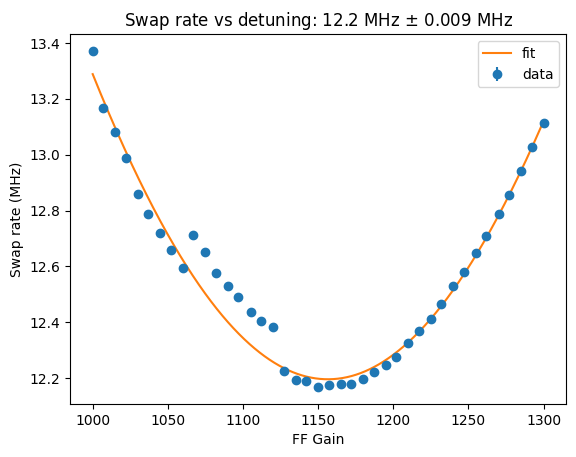

12.196405401805142


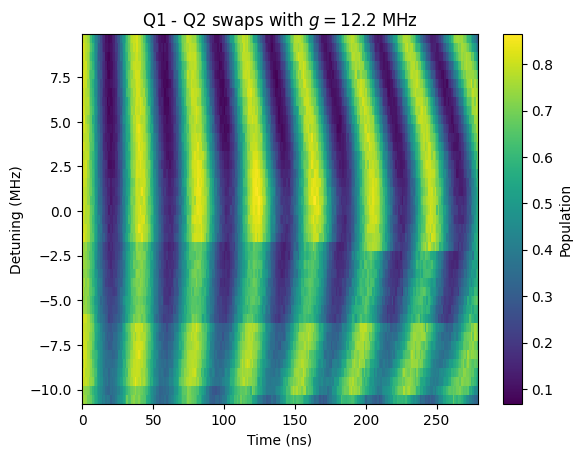

1156.4927801361482


In [12]:
test_filename = generate_swaps_filename('2025', '04', '26', '00', '21', '31')
# test_filename = generate_swaps_filename('2025', '04', '26', '16', '36', '59')
test_measurement = QubitSwapMeasurement('Q1', 'Q2', test_filename, exp_end_index=66)

test_measurement.acquire_data()



print(test_measurement.get_coupling_strength(plot_sin_fits=False, plot_fft=False, plot_sin_errors=False, plot_swap_rates_fit=True))

test_measurement.plot_chevron_vs_detuning()

print(test_measurement.get_ff_gain_center())

In [13]:
test_filename = generate_swaps_filename('2025', '02', '17', '22', '15', '37')
test_measurement = QubitSwapMeasurement('Q1', 'Q3', test_filename, exp_end_index=None)

test_measurement.acquire_data()



print(test_measurement.get_coupling_strength(plot_sin_fits=False, plot_fft=False, plot_sin_errors=False, plot_swap_rates_fit=True))

test_measurement.plot_chevron_vs_detuning()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'V:\QSimMeasurements\Measurements\4Q_Test_Scalinq\QubitOscillations_GainSweepMUX\QubitOscillations_GainSweepMUX_2025_02_17\QubitOscillations_GainSweepMUX_2025_02_17_22_15_37_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
test_filename = generate_swaps_filename('2025', '02', '18', '11', '08', '41')
test_measurement = QubitSwapMeasurement('Q1', 'Q3', test_filename, exp_end_index=None)

test_measurement.acquire_data()



print(test_measurement.get_coupling_strength(plot_sin_fits=False, plot_fft=False, plot_sin_errors=False, plot_swap_rates_fit=True))

test_measurement.plot_chevron_vs_detuning()

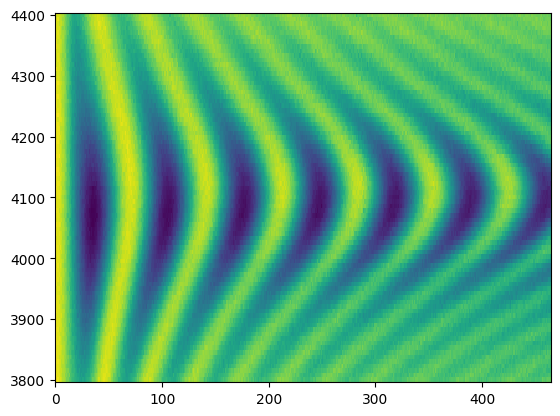

# 2. Measure Coupling

### 2.1 Q1-Q3 Tunable Coupling

Swaps between Q1 and Q3 with coupler at -0.33 V
coupling strength: 9.24 MHz
swap rate fit popt: [9.24000e+00 6.00000e-02 4.20384e+03]


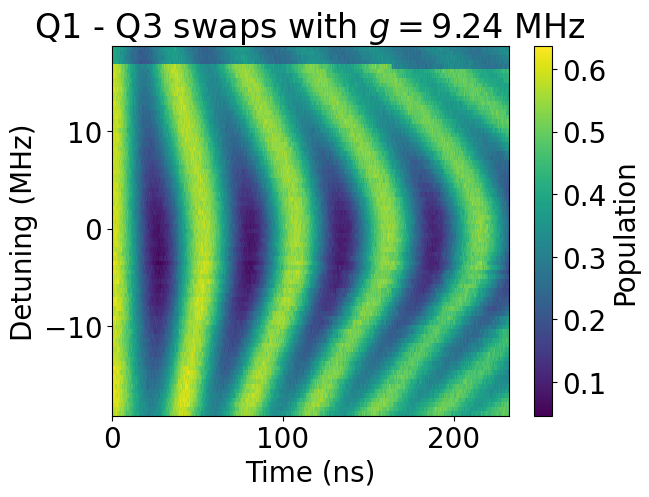


Swaps between Q1 and Q3 with coupler at 0.3 V
coupling strength: 13.75 MHz
swap rate fit popt: [1.37500e+01 6.00000e-02 3.73149e+03]


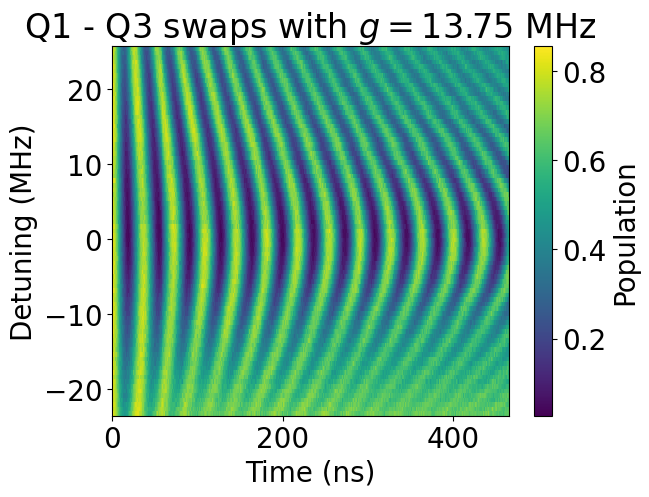


Swaps between Q1 and Q3 with coupler at 0.5 V
coupling strength: 7.05 MHz
swap rate fit popt: [7.05000e+00 6.00000e-02 4.11149e+03]


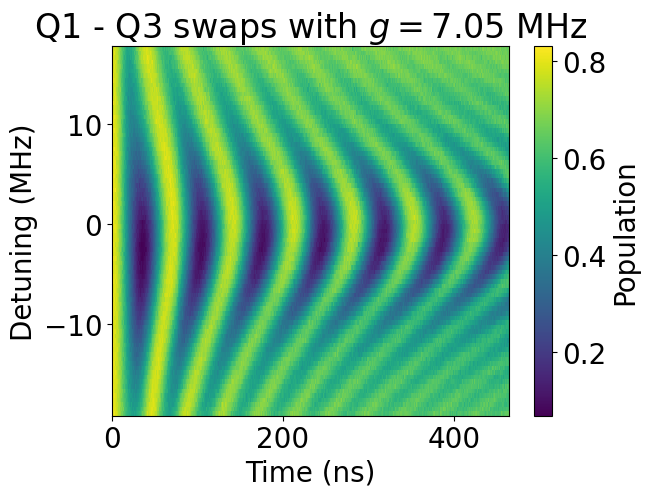


Swaps between Q1 and Q3 with coupler at 1.2 V
coupling strength: 3.93 MHz
swap rate fit popt: [3.93000e+00 6.00000e-02 4.25117e+03]


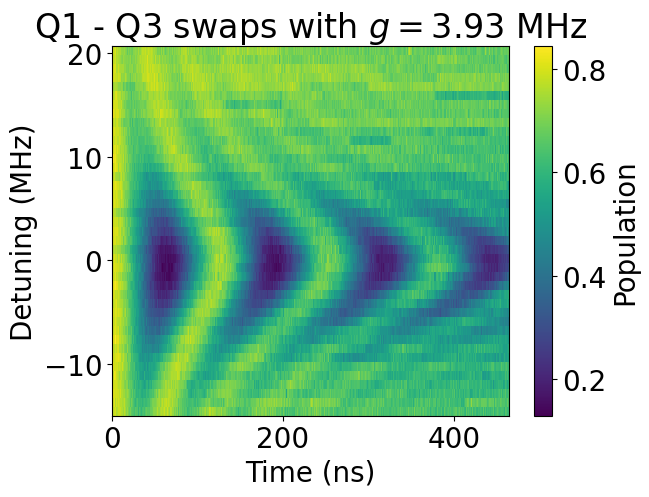


Swaps between Q1 and Q3 with coupler at 1.0 V
coupling strength: 3.96 MHz
swap rate fit popt: [3.96000e+00 6.00000e-02 3.97948e+03]


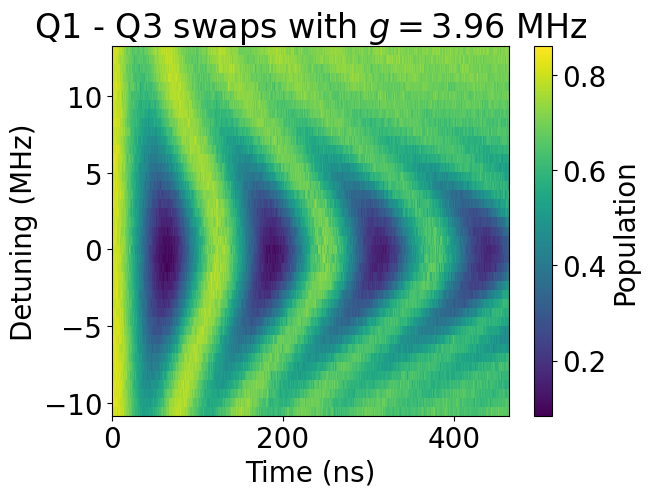


Swaps between Q1 and Q3 with coupler at 0.8 V
coupling strength: 4.5 MHz
swap rate fit popt: [4.50000e+00 6.00000e-02 3.71026e+03]


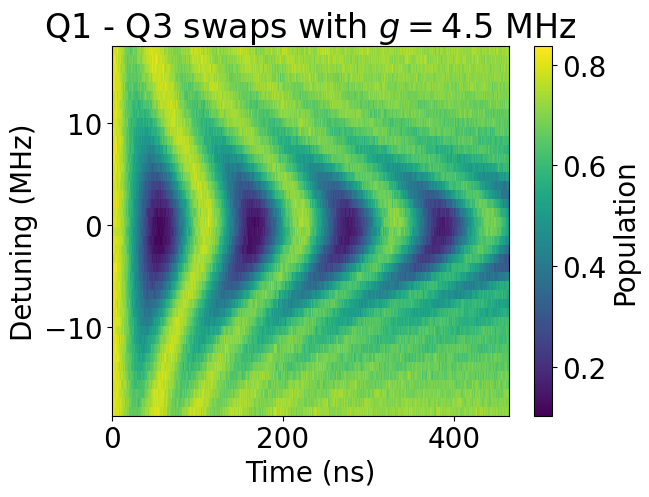


Swaps between Q1 and Q3 with coupler at 0.6 V
coupling strength: 5.83 MHz
swap rate fit popt: [5.83000e+00 6.00000e-02 3.43282e+03]


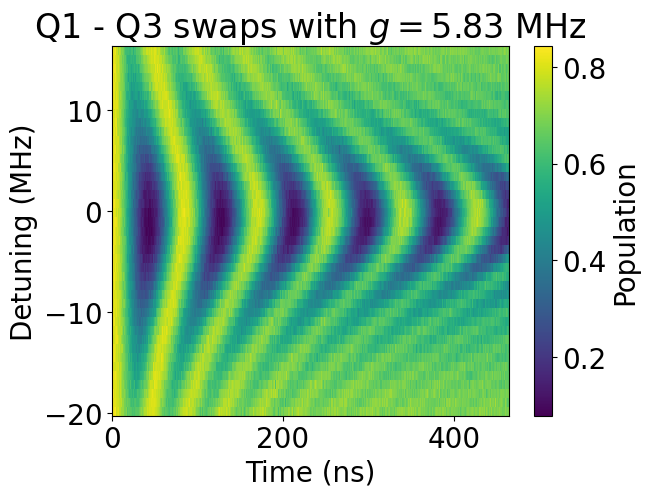


Swaps between Q1 and Q3 with coupler at 0.1 V
coupling strength: 55.35 MHz
swap rate fit popt: [5.53500e+01 5.00000e-02 7.30323e+03]


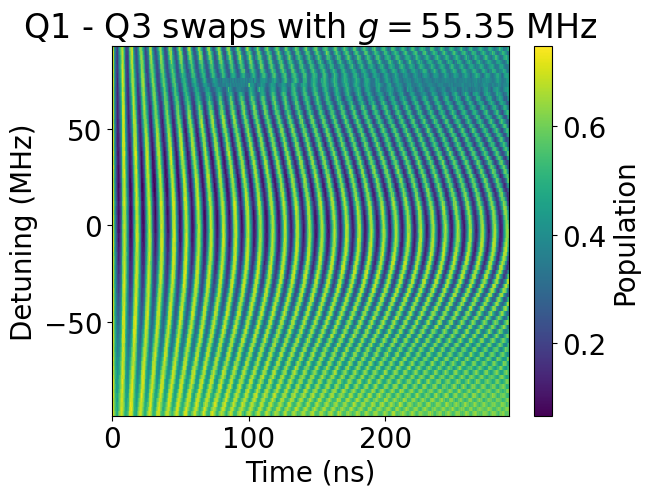


Swaps between Q1 and Q3 with coupler at -0.2 V
coupling strength: 12.96 MHz
swap rate fit popt: [1.29600e+01 6.00000e-02 7.29491e+03]


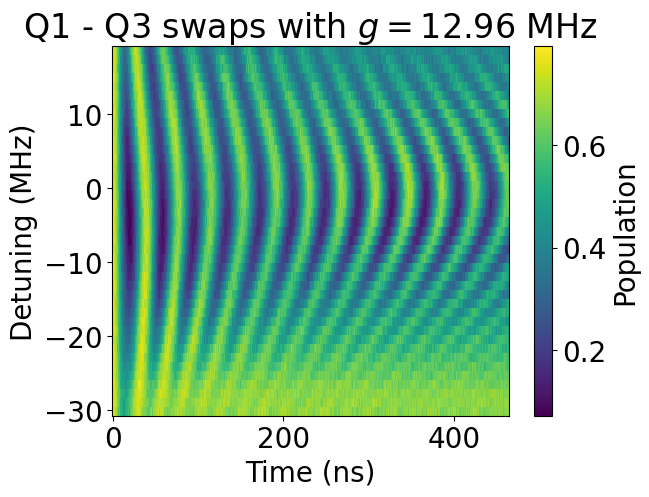


Swaps between Q1 and Q3 with coupler at -0.4 V
coupling strength: 9.89 MHz
swap rate fit popt: [9.8900e+00 6.0000e-02 7.0239e+03]


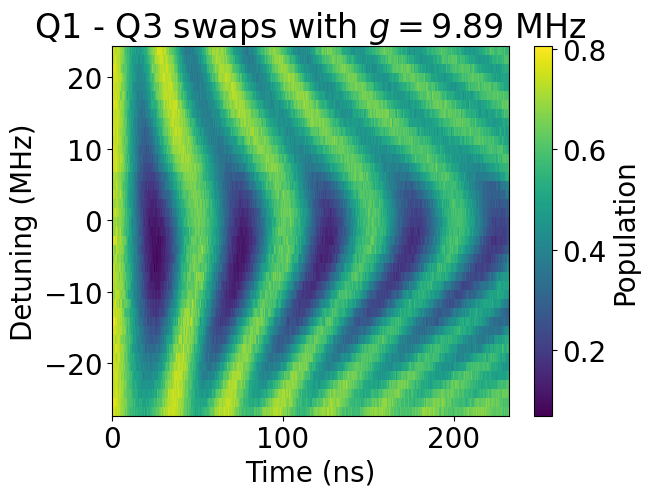


Swaps between Q1 and Q3 with coupler at -0.5 V
coupling strength: 13.14 MHz
swap rate fit popt: [1.31400e+01 6.00000e-02 6.86762e+03]


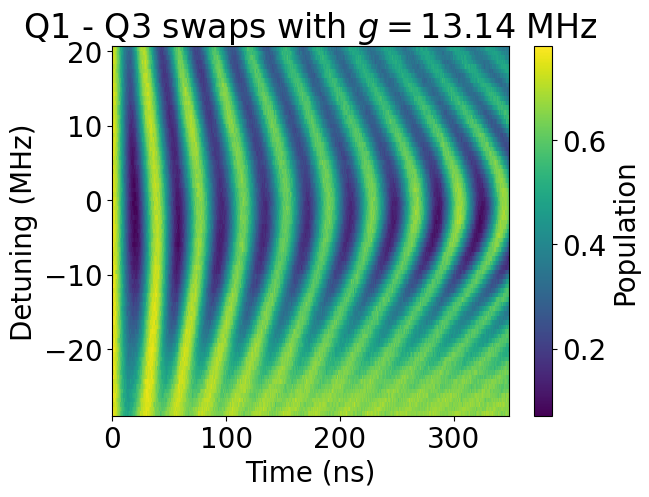


Swaps between Q1 and Q3 with coupler at -0.6 V
coupling strength: 9.89 MHz
swap rate fit popt: [9.8900e+00 6.0000e-02 7.0239e+03]


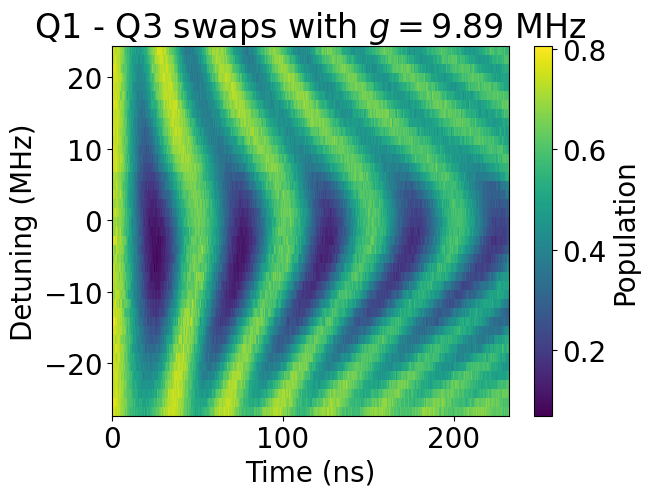

In [371]:
### Q1 Q3 swaps

Q1_Q3_swaps = []
qubit_1 = 'Q1'
qubit_2 = 'Q3'

Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '14', '22', '45', '32'), coupler_voltage=-0.3328404))

# Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '16', '12', '13', '05'), coupler_voltage=0.3))
# redo the one above in the future
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '03', '06', '17', '04', '16'), coupler_voltage=0.3))

Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '16', '21', '56', '50'), coupler_voltage=0.5))

# might need to ignore some indices for this one
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '09', '29', '40'), coupler_voltage=1.2))
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '11', '16', '23'), coupler_voltage=1.0))
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '13', '01', '10'), coupler_voltage=0.8))
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '14', '46', '06'), coupler_voltage=0.6))

# 0.1 medium quality
# Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '17', '16', '10'), coupler_voltage=0.1))
# 0.1 higher quality
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '22', '15', '37'), coupler_voltage=0.1))


Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '17', '20', '41', '32'), coupler_voltage=-0.2))
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '18', '09', '33', '56'), coupler_voltage=-0.4))
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '19', '00', '53', '27'), coupler_voltage=-0.5))
Q1_Q3_swaps.append(QubitSwapMeasurement(qubit_1, qubit_2, generate_swaps_filename('2025', '02', '18', '09', '33', '56'), coupler_voltage=-0.6))

for i in range(len(Q1_Q3_swaps)):
    swap_measurement = Q1_Q3_swaps[i]
    
    coupler_voltage = swap_measurement.get_meta_param('coupler_voltage')
    qubit_1 = swap_measurement.qubit_1
    qubit_2 = swap_measurement.qubit_2
    
    
    print(f'Swaps between {qubit_1} and {qubit_2} with coupler at {np.round(coupler_voltage, 2)} V')
    print(f'coupling strength: {np.round(swap_measurement.get_coupling_strength(plot_swap_rates_fit=False), 2)} MHz')  
    
    print(f'swap rate fit popt: {np.round(swap_measurement.swap_rate_fit_popt, 2)}')
    
    swap_measurement.plot_chevron_vs_detuning()
    
    print()

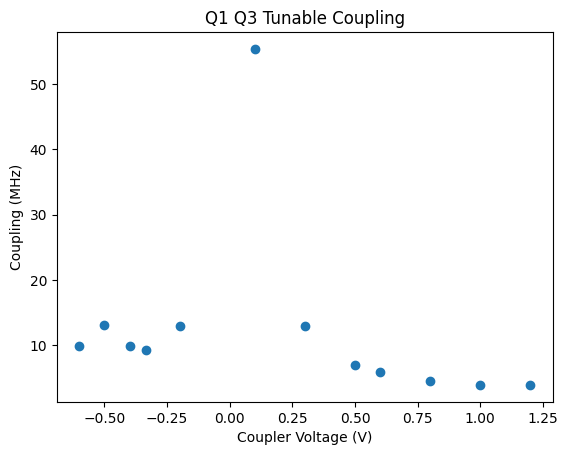

In [243]:
### plot coupling vs coupler voltage

coupling_strengths = np.zeros(len(Q1_Q3_swaps))
coupler_voltages = np.zeros(len(Q1_Q3_swaps))

for i in range(len(Q1_Q3_swaps)):
    
    swap_measurement = Q1_Q3_swaps[i]
    
    coupler_voltage = swap_measurement.get_meta_param('coupler_voltage')
    qubit_1 = swap_measurement.qubit_1
    qubit_2 = swap_measurement.qubit_2
    
    coupling_strengths[i] = swap_measurement.get_coupling_strength()
    coupler_voltages[i] = coupler_voltage
    
plt.plot(coupler_voltages, coupling_strengths, linestyle='', marker='o')

plt.xlabel('Coupler Voltage (V)')
plt.ylabel('Coupling (MHz)')

plt.title('Q1 Q3 Tunable Coupling')

plt.show()

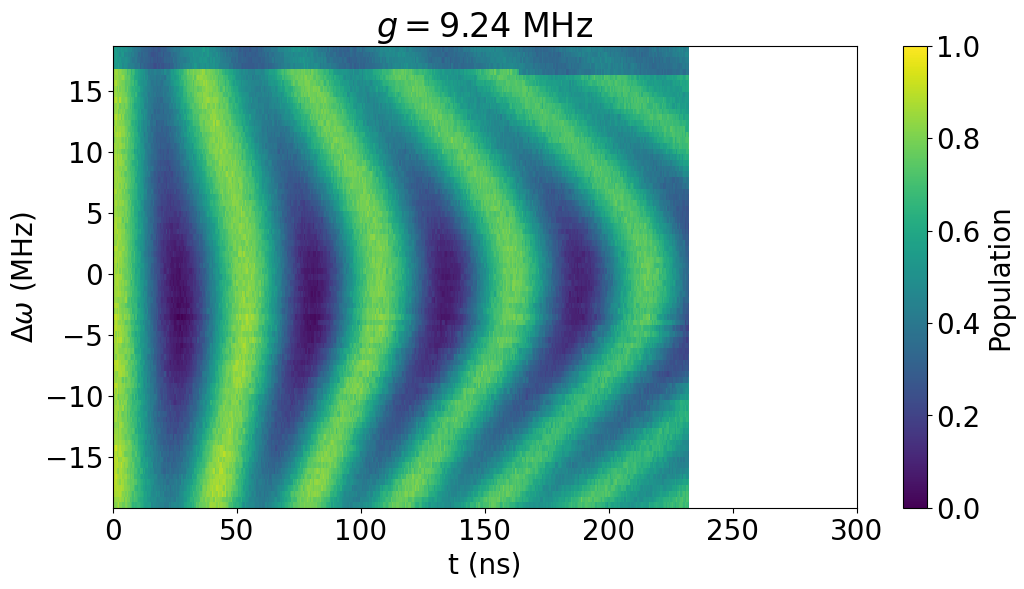

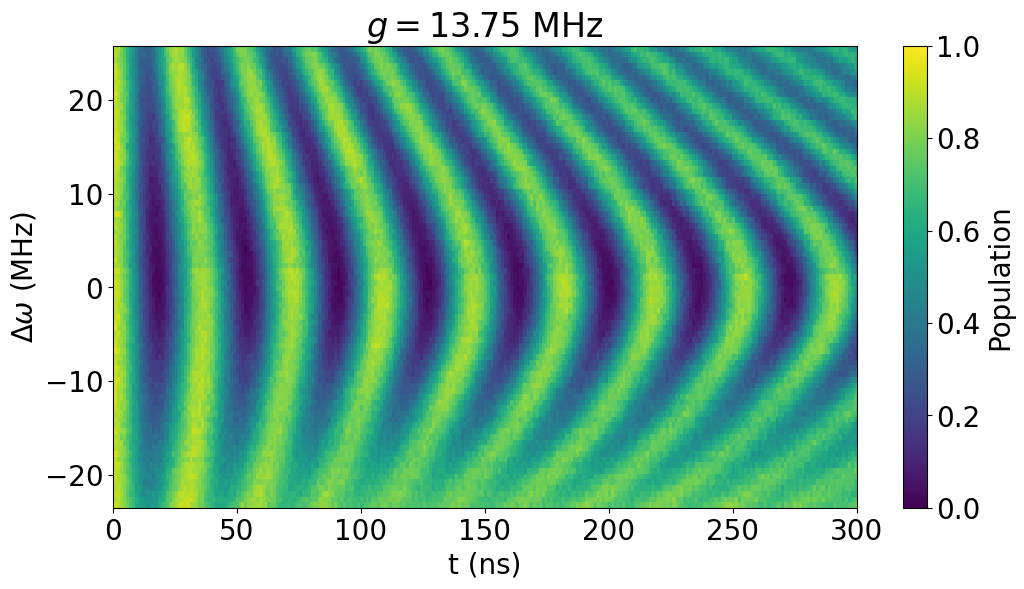

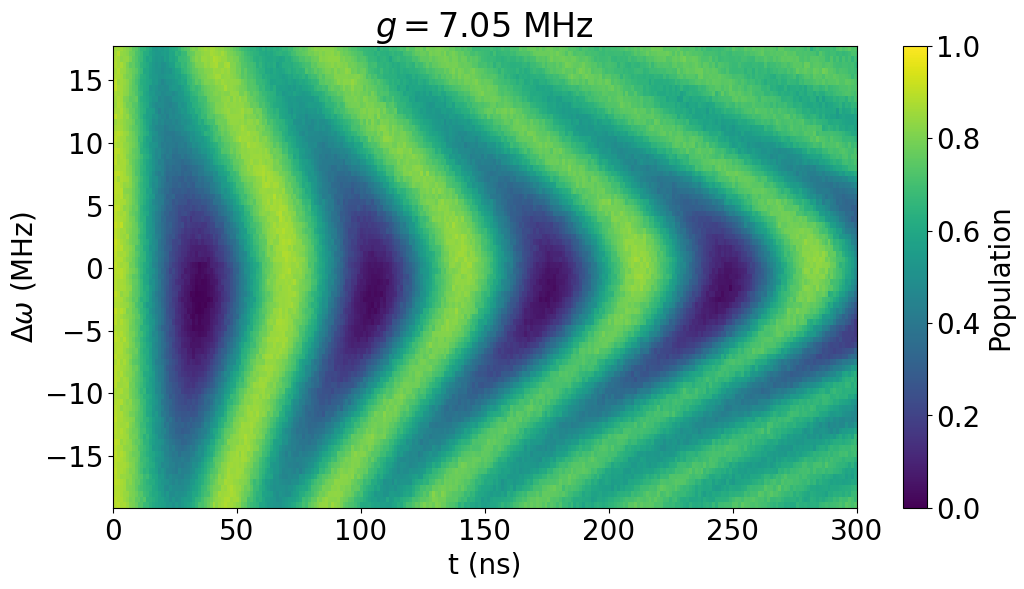

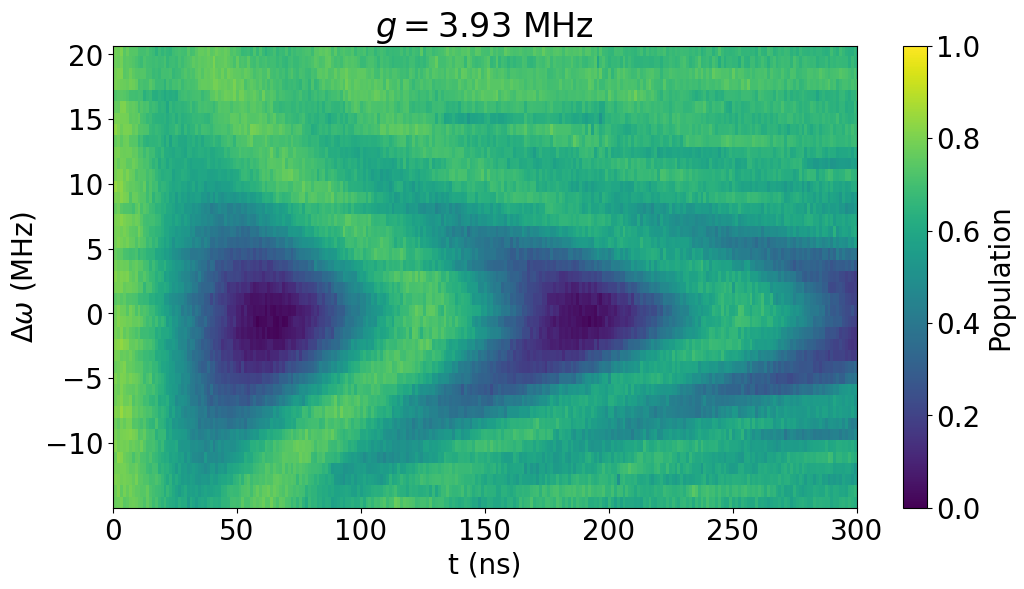

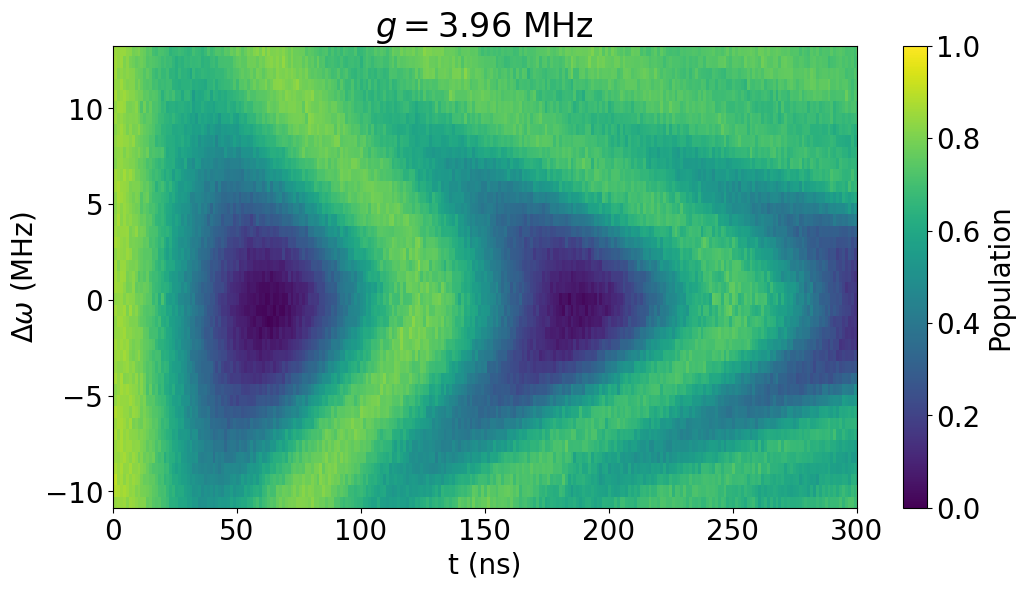

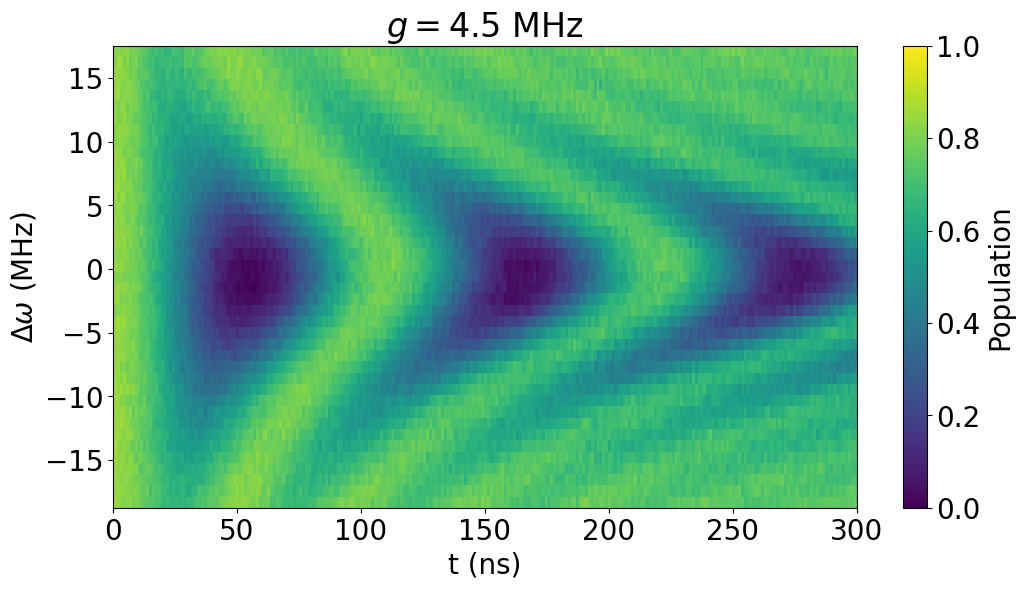

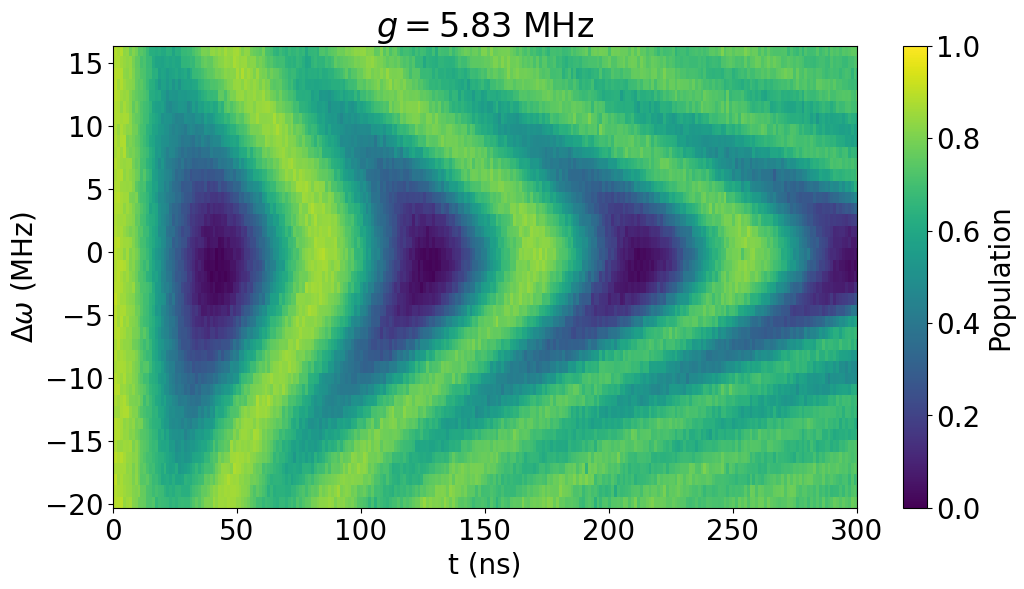

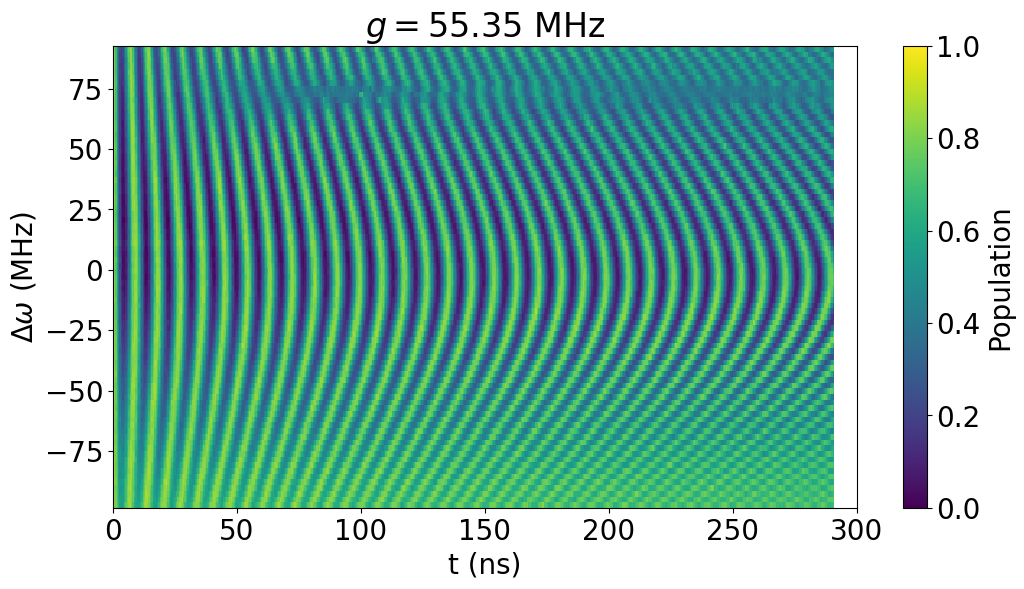

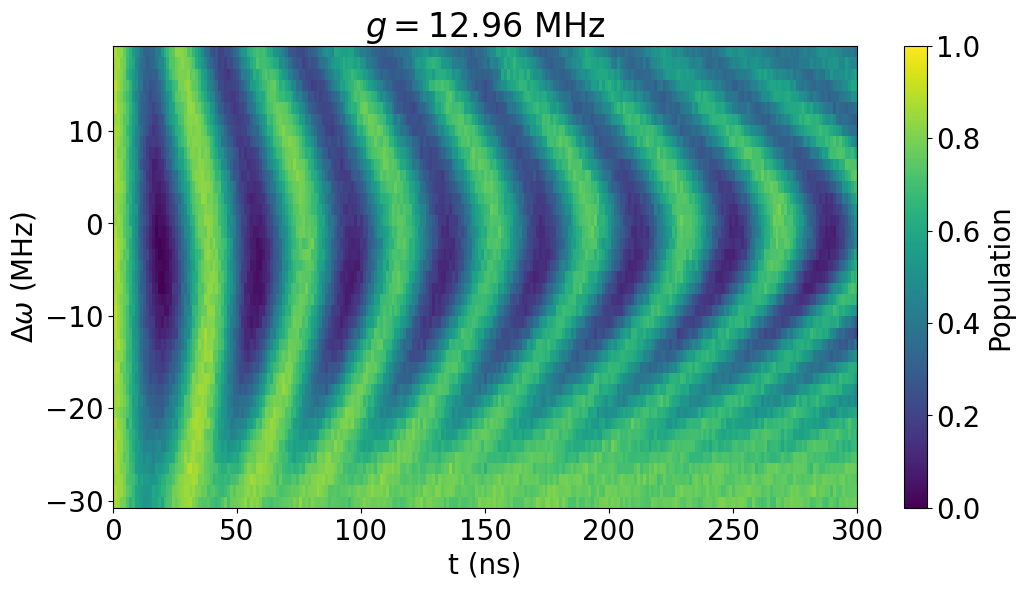

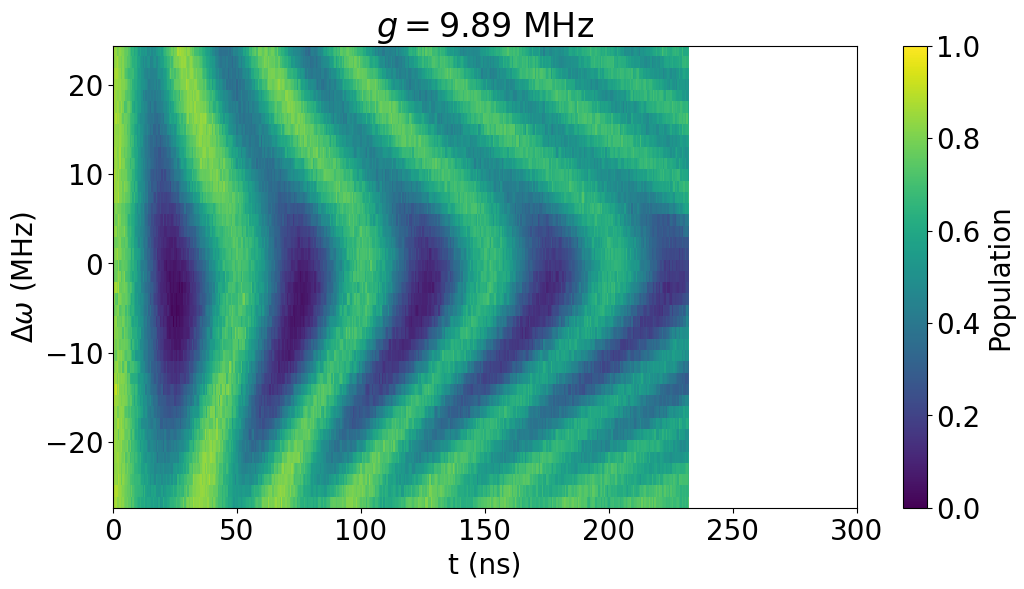

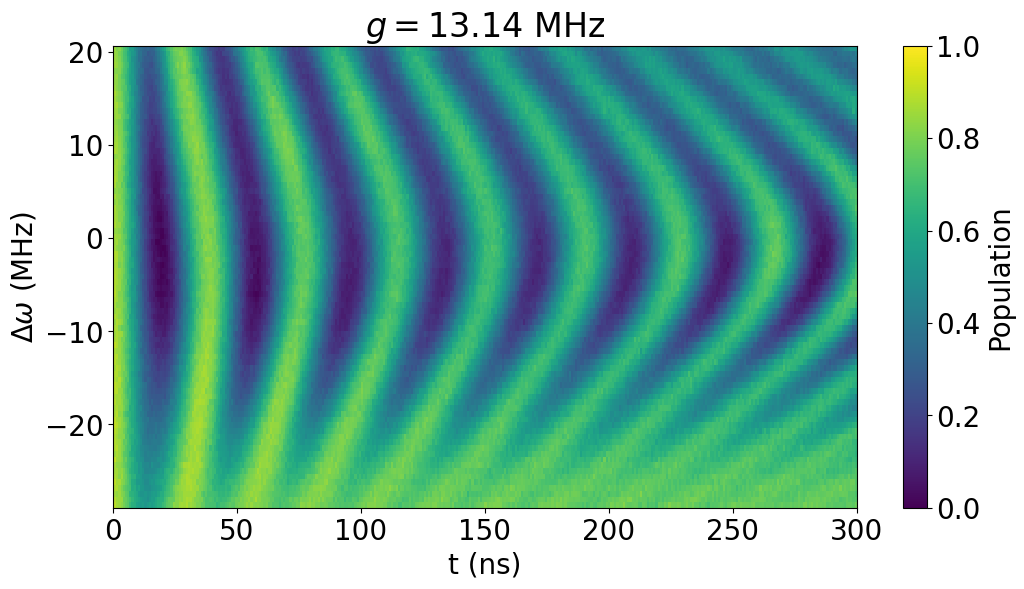

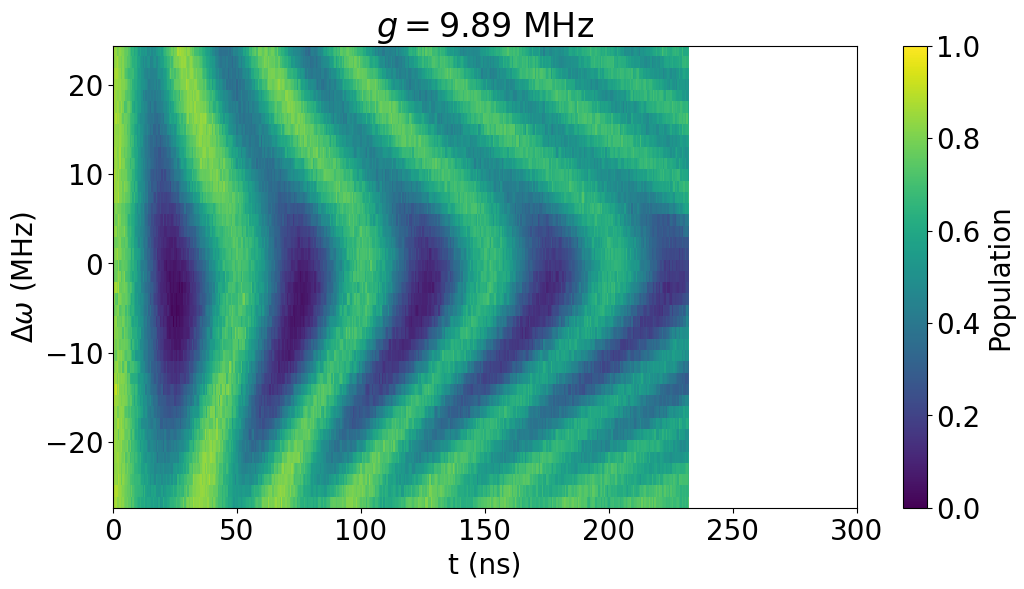

In [372]:
### plot chevrons for presentation

plt.rcParams['font.size'] = 20

for i in range(len(Q1_Q3_swaps)):
    swap_measurement = Q1_Q3_swaps[i]
    
    x = swap_measurement.get_times()
    ff_gains = swap_measurement.get_ff_gains()
    z = swap_measurement.get_populations()
    
    
    z_max = np.max(z)
    z_min = np.min(z)
    z_range = z_max - z_min
    
    z = (z - z_min)/z_max
    
    
    swap_rate_fit_popt = swap_measurement.get_swap_rate_fit_popt()
        
    g = swap_rate_fit_popt[0]
    A = swap_rate_fit_popt[1]
    x0 = swap_rate_fit_popt[2]

    detunings = A*(ff_gains - x0)
    y = detunings
    
    x_step = x[1] - x[0]
    y_step = y[1] - y[0]
    
    plt.figure(figsize=(12, 6))

    plt.imshow(z[0,:,:], aspect='auto', origin='lower', interpolation='none', extent=(x[0] - x_step/2, x[-1] + x_step/2, y[0] - y_step/2, y[-1] + y_step/2),
              vmin=0, vmax=1)

    plt.xlabel('t (ns)')
    plt.ylabel(r'$\Delta\omega$ (MHz)')
    
    plt.xlim(0, 300)

    colorbar_label = 'Population'

    plt.colorbar(label=colorbar_label)

    title = f'$g = {np.round(swap_measurement.get_coupling_strength(), 2)}$ MHz'
    plt.title(title)

    plt.show()
    


### 2.1 Q1-Q2 and Q2-Q3 Fixed Coupling

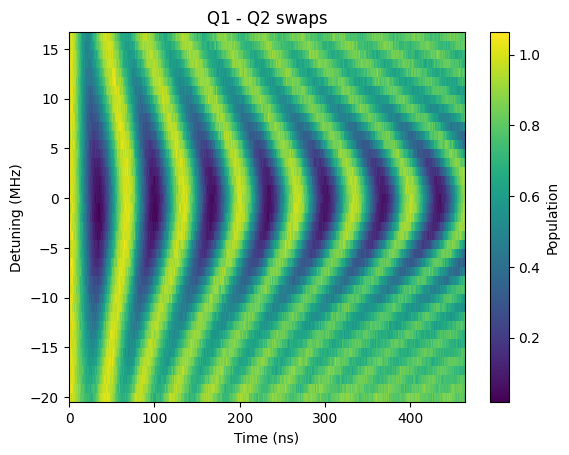

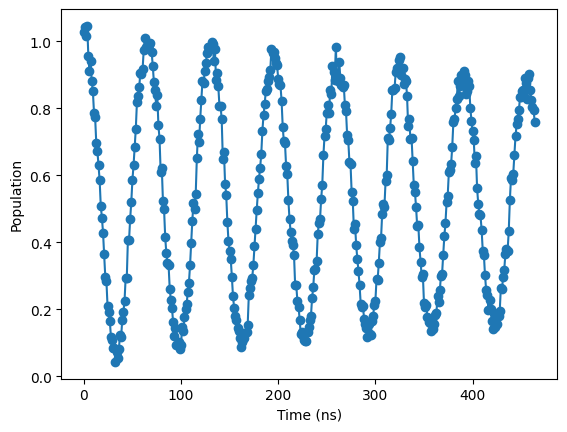

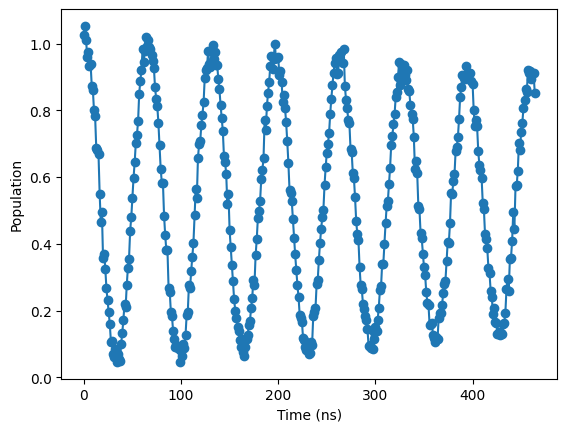

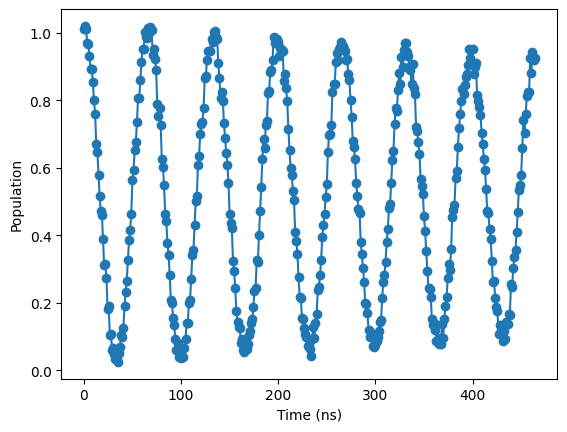

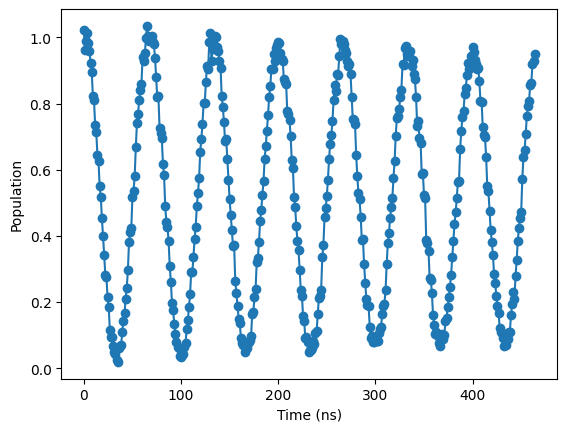

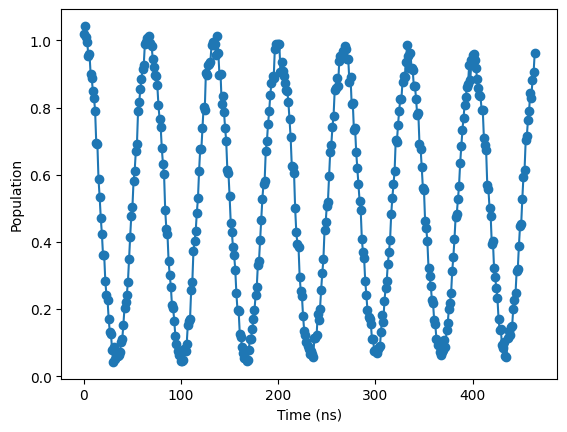

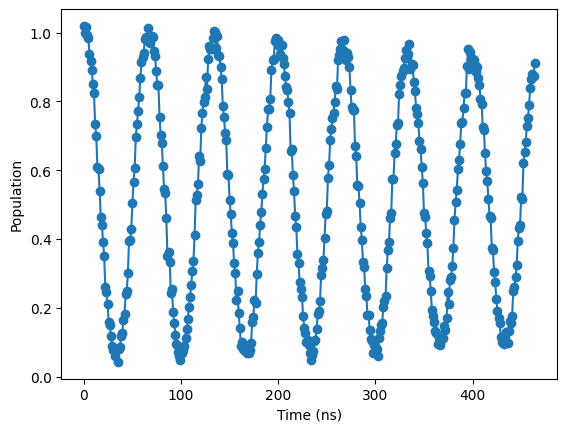

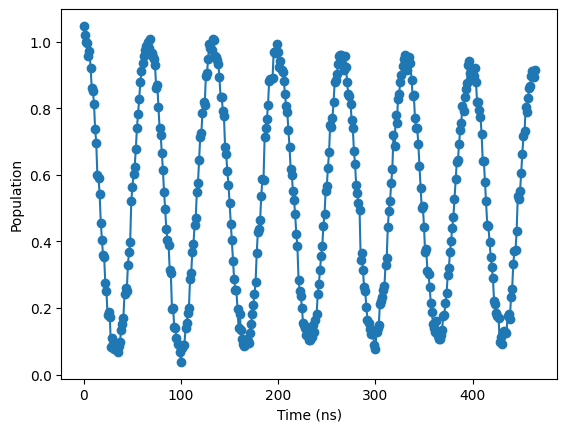

Q1-Q2 coupling: 7.49 MHz


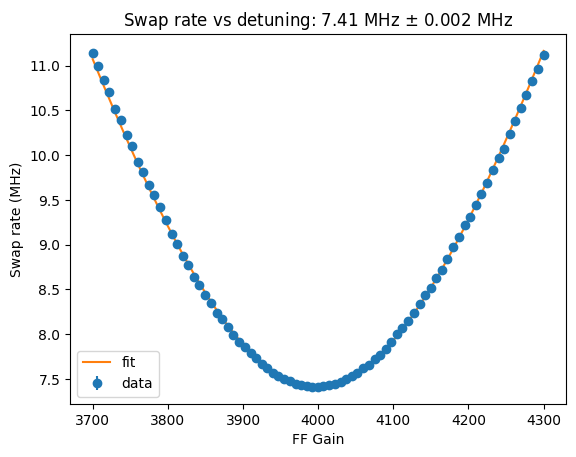

Q1-Q2 coupling: 7.41 MHz


In [321]:
### Fixed coupling

# Q1-Q2
q1_q2_swap = QubitSwapMeasurement('Q1', 'Q2', generate_swaps_filename('2025', '02', '18', '14', '11', '00'), singleshot_filename=generate_singleshot_filename('2025', '02', '18', '14', '10', '47'), readout_qubit='Q1')
q1_q2_swap.plot_chevron_vs_detuning(True)
for i in range(18, 25):
    q1_q2_swap.plot_trace(i, True)
q1_q2_coupling = q1_q2_swap.get_coupling_strength(plot_swap_rates_fit=True)
print(f'Q1-Q2 coupling: {np.round(q1_q2_coupling, 2)} MHz')

# Q2-Q3
q2_q3_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '18', '19', '57', '34'), readout_qubit='Q2')
q2_q3_coupling = q2_q3_swap.get_coupling_strength(plot_swap_rates_fit=True)
print(f'Q1-Q2 coupling: {np.round(q2_q3_coupling, 2)} MHz')

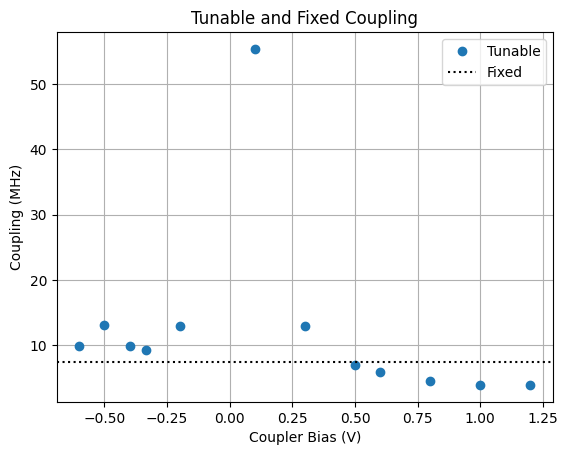

In [349]:
### plot coupling vs coupler voltage

coupling_strengths = np.zeros(len(Q1_Q3_swaps))
coupler_voltages = np.zeros(len(Q1_Q3_swaps))

for i in range(len(Q1_Q3_swaps)):
    
    swap_measurement = Q1_Q3_swaps[i]
    
    coupler_voltage = swap_measurement.get_meta_param('coupler_voltage')
    qubit_1 = swap_measurement.qubit_1
    qubit_2 = swap_measurement.qubit_2
    
    coupling_strengths[i] = swap_measurement.get_coupling_strength()
    coupler_voltages[i] = coupler_voltage
    
plt.plot(coupler_voltages, coupling_strengths, linestyle='', marker='o', label='Tunable')

plt.xlabel('Coupler Bias (V)')
plt.ylabel('Coupling (MHz)')

plt.title('Tunable and Fixed Coupling')

plt.axhline(q1_q2_coupling, color='black', linestyle=':', label='Fixed')
# plt.axhline(2*q1_q2_coupling, color='gray', linestyle=':', label='Q1-Q2 x2')

# plt.axhline(q1_q2_coupling, color='red', linestyle=':', label='Q2-Q3')
# plt.axhline(2*q1_q2_coupling, color='pink', linestyle=':', label='Q2-Q3 x2')

plt.grid()
plt.legend()

plt.show()

### 3. Measure FF Gain
This section is used to figure out the optimal FF gain to put two qubits onto resonance

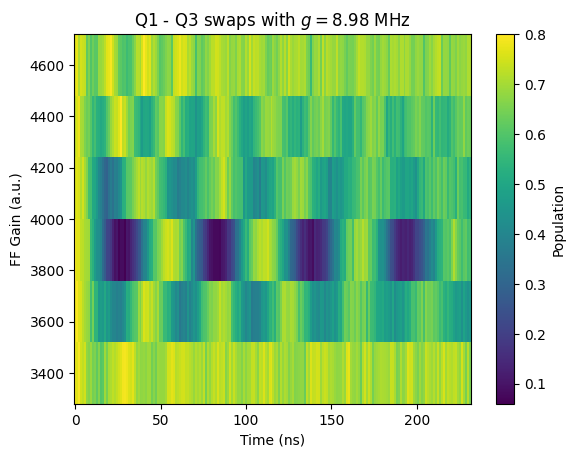

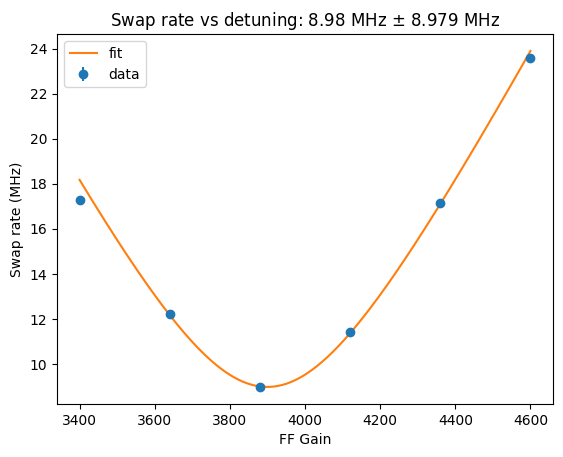

3899.637743399391


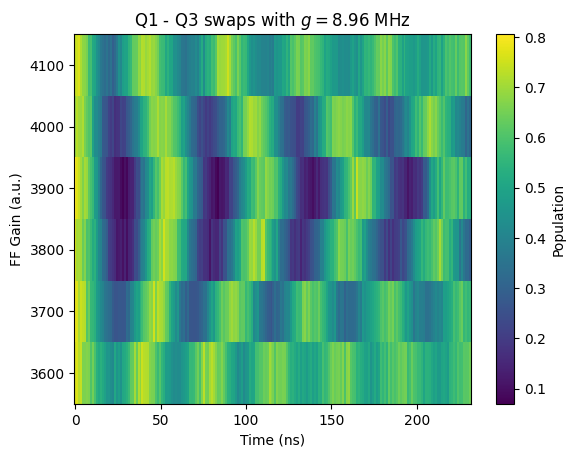

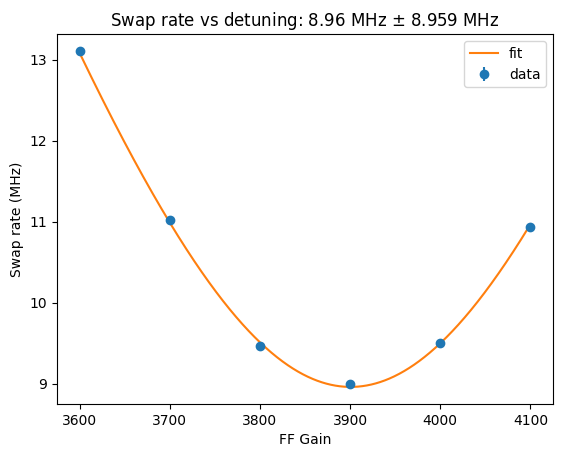

3900.559398399585


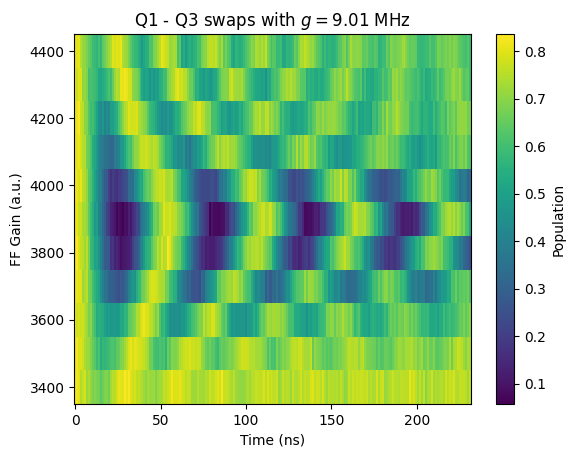

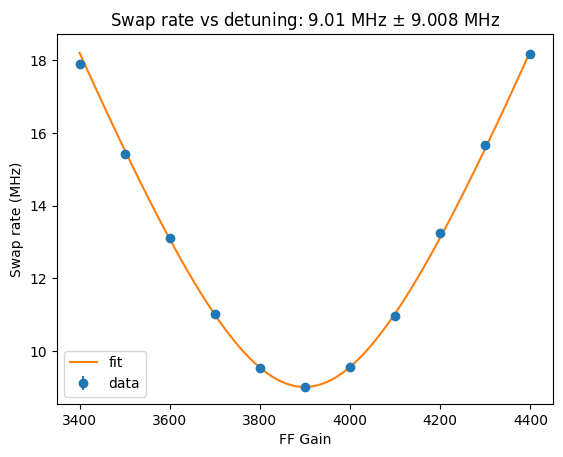

3899.0427622683355


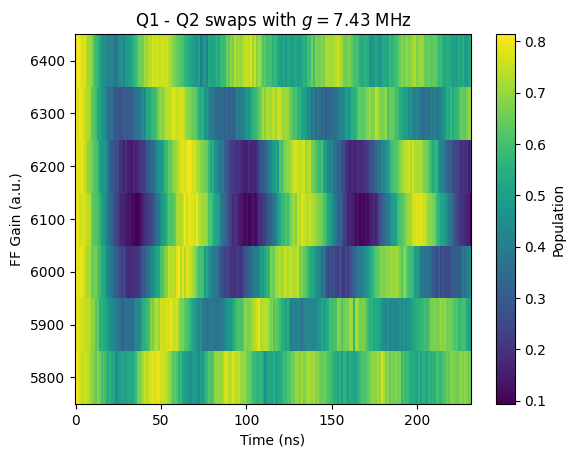

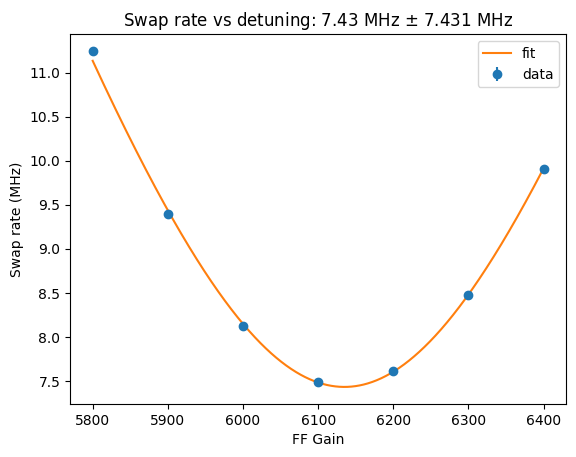

6134.92833196841


In [263]:
q1_q3_test_swap = QubitSwapMeasurement('Q1', 'Q3', generate_swaps_filename('2025', '02', '20', '10', '54', '56'))
q1_q3_test_swap.plot_chevron_vs_gain()
q1_q3_test_swap.plot_swap_rate_fit()
print(q1_q3_test_swap.get_ff_gain_center())

q1_q3_test_swap = QubitSwapMeasurement('Q1', 'Q3', generate_swaps_filename('2025', '02', '20', '11', '40', '51'))
q1_q3_test_swap.plot_chevron_vs_gain()
q1_q3_test_swap.plot_swap_rate_fit()
print(q1_q3_test_swap.get_ff_gain_center())

q1_q3_test_swap = QubitSwapMeasurement('Q1', 'Q3', generate_swaps_filename('2025', '02', '20', '13', '39', '42'))
q1_q3_test_swap.plot_chevron_vs_gain()
q1_q3_test_swap.plot_swap_rate_fit()
print(q1_q3_test_swap.get_ff_gain_center())

q1_q2_test_swap = QubitSwapMeasurement('Q1', 'Q2', generate_swaps_filename('2025', '02', '20', '11', '52', '34'))
q1_q2_test_swap.plot_chevron_vs_gain()
q1_q2_test_swap.plot_swap_rate_fit()
print(q1_q2_test_swap.get_ff_gain_center())

### 3.2 3Q Swaps

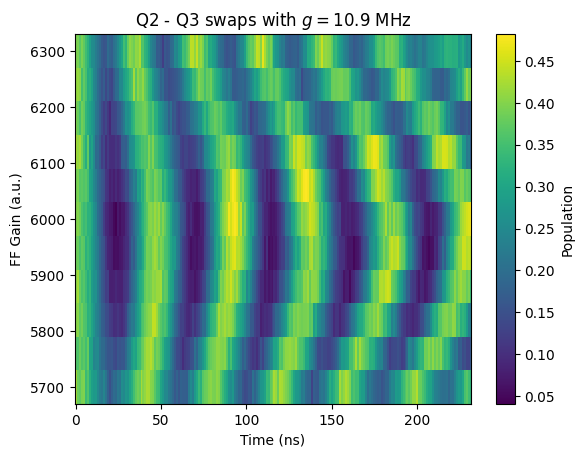

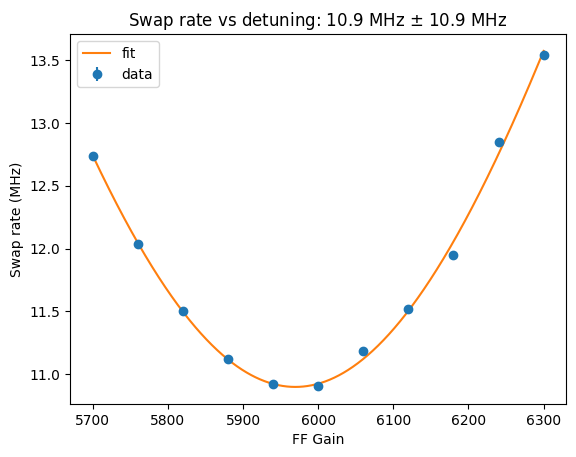

5969.577798851239


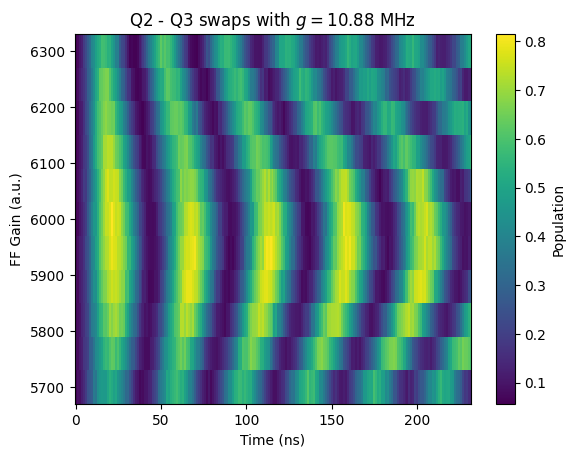

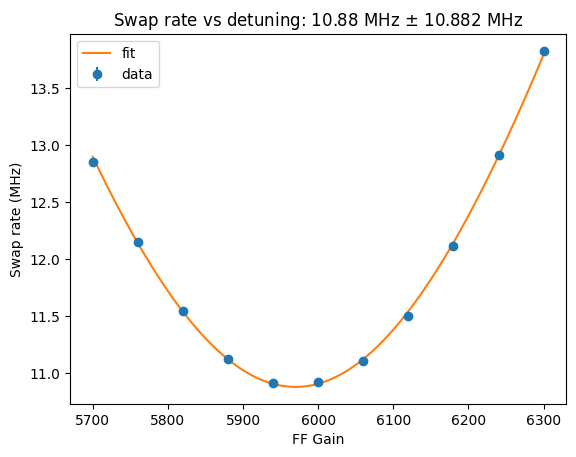

5969.825071510022


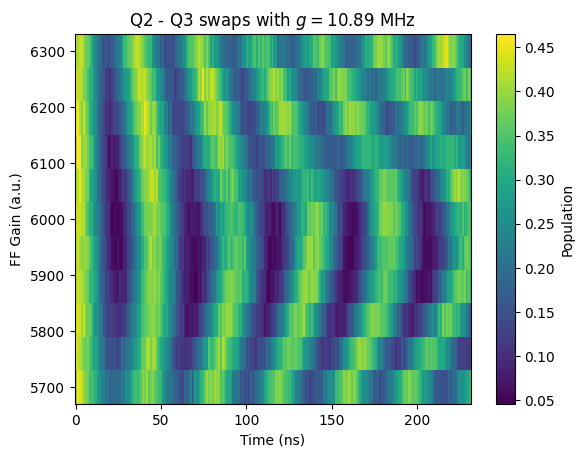

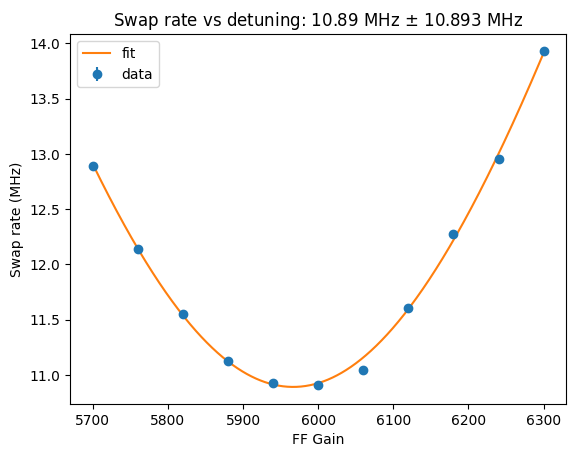

5966.734788612029


In [266]:
readout_Q1_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '20', '17', '16', '46'), readout_qubit='Q1')
readout_Q1_test_swap.plot_chevron_vs_gain()
readout_Q1_test_swap.plot_swap_rate_fit()
print(readout_Q1_test_swap.get_ff_gain_center())

readout_Q2_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '20', '16', '25', '34'), readout_qubit='Q2')
readout_Q2_test_swap.plot_chevron_vs_gain()
readout_Q2_test_swap.plot_swap_rate_fit()
print(readout_Q2_test_swap.get_ff_gain_center())

readout_Q3_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '20', '16', '38', '07'), readout_qubit='Q3')
readout_Q3_test_swap.plot_chevron_vs_gain()
readout_Q3_test_swap.plot_swap_rate_fit()
print(readout_Q3_test_swap.get_ff_gain_center())

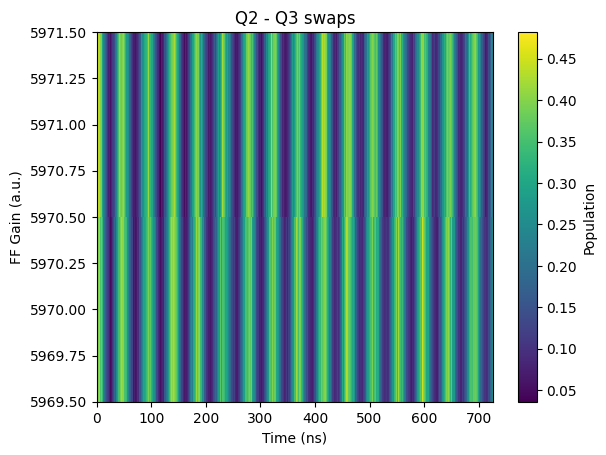

(1, 2, 1001)


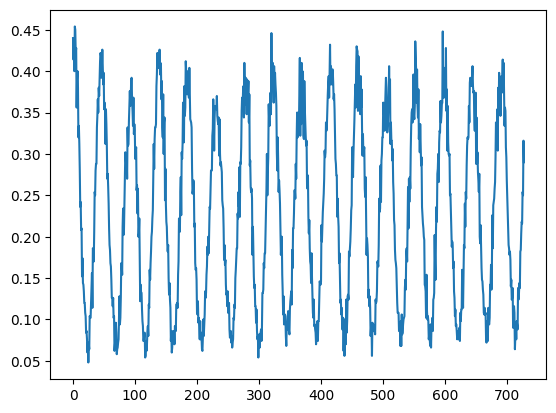

In [278]:
test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '20', '19', '46', '41'), readout_qubit='Q1')
test_swap.plot_chevron_vs_gain()

populations = test_swap.get_populations()
times = test_swap.get_times()

print(populations.shape)
plt.plot(times, populations[0, 0, :])

#### 3.2.2 Positive coupling
new coupler point

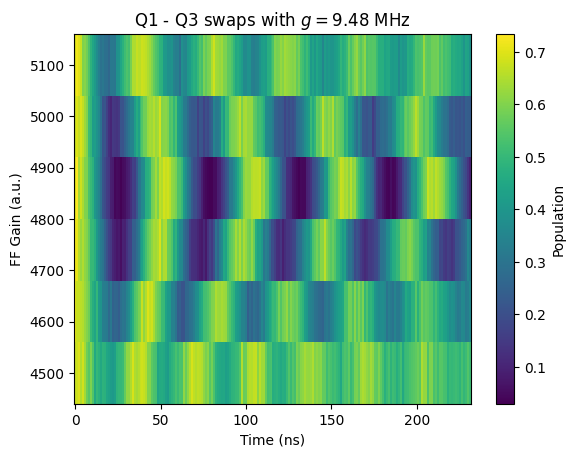

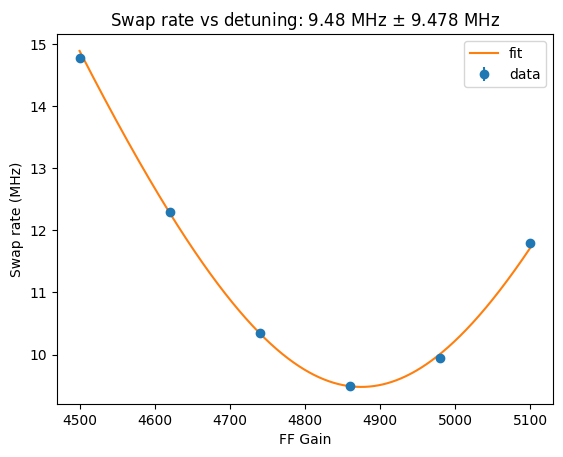

4874.799541523354


In [280]:
q1_q3_test_swap = QubitSwapMeasurement('Q1', 'Q3', generate_swaps_filename('2025', '02', '21', '14', '00', '21'))
q1_q3_test_swap.get_coupling_strength()
q1_q3_test_swap.plot_chevron_vs_gain()
q1_q3_test_swap.plot_swap_rate_fit()
print(q1_q3_test_swap.get_ff_gain_center())

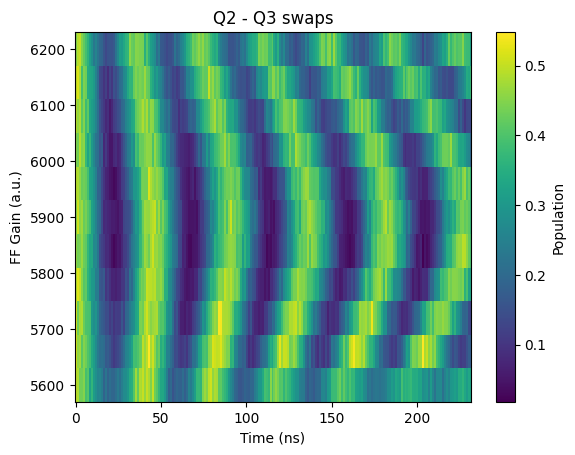

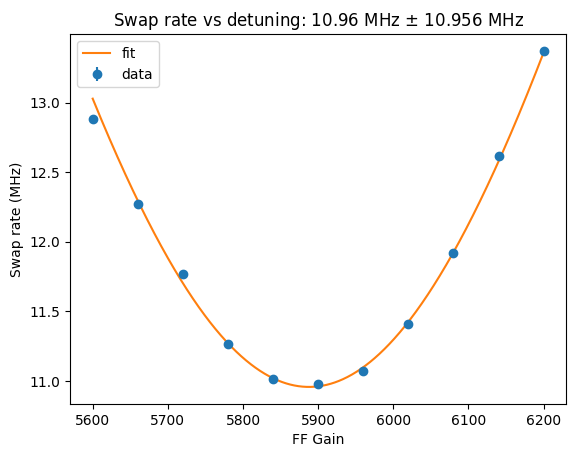

5887.853280391819


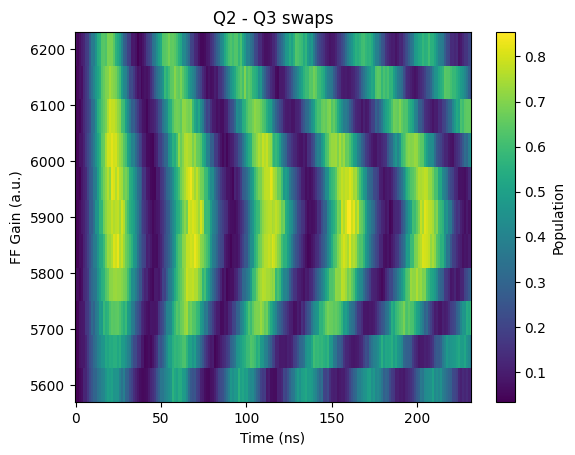

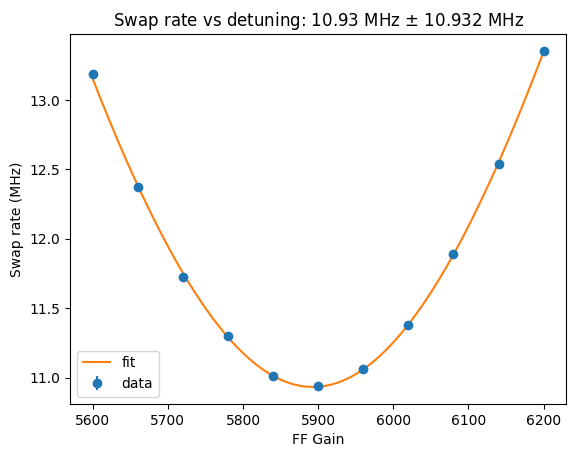

5893.044846815461


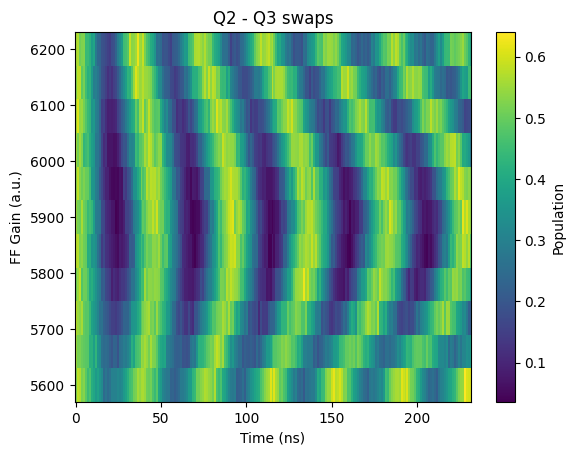

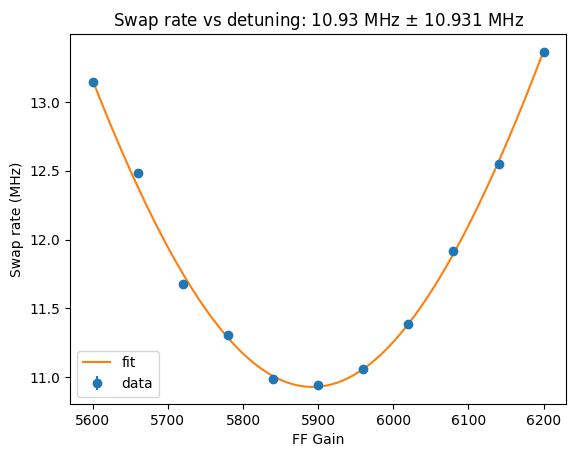

5892.444681866678


In [285]:
readout_Q1_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '21', '14', '52', '17'), readout_qubit='Q1')
readout_Q1_test_swap.plot_chevron_vs_gain()
readout_Q1_test_swap.plot_swap_rate_fit()
print(readout_Q1_test_swap.get_ff_gain_center())

readout_Q2_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '21', '16', '00', '14'), readout_qubit='Q2')
readout_Q2_test_swap.plot_chevron_vs_gain()
readout_Q2_test_swap.plot_swap_rate_fit()
print(readout_Q2_test_swap.get_ff_gain_center())

readout_Q3_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '21', '15', '08', '35'), readout_qubit='Q3')
readout_Q3_test_swap.plot_chevron_vs_gain()
readout_Q3_test_swap.plot_swap_rate_fit()
print(readout_Q3_test_swap.get_ff_gain_center())

In [343]:
readout_Q2_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '28', '11', '26', '54'), readout_qubit='Q2')
print(readout_Q2_test_swap.get_coupling_strength(exp_start_index=1))
readout_Q2_test_swap.plot_chevron_vs_gain()
readout_Q2_test_swap.plot_swap_rate_fit()
print(readout_Q3_test_swap.get_ff_gain_center())

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'V:\QSimMeasurements\Measurements\5QV2_Triangle_Lattice\AdiabaticRampOscillationsGainSweep\AdiabaticRampOscillationsGainSweep_2025_02_28\AdiabaticRampOscillationsGainSweep_2025_02_28_11_26_54_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### 3.3 3Q Swaps with Adiabatic Ramp

10.89880734576686


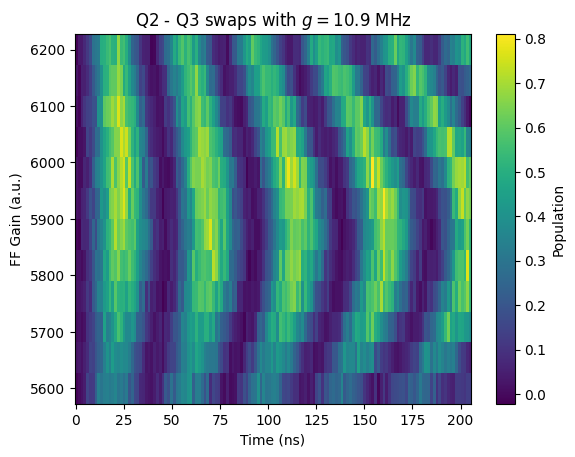

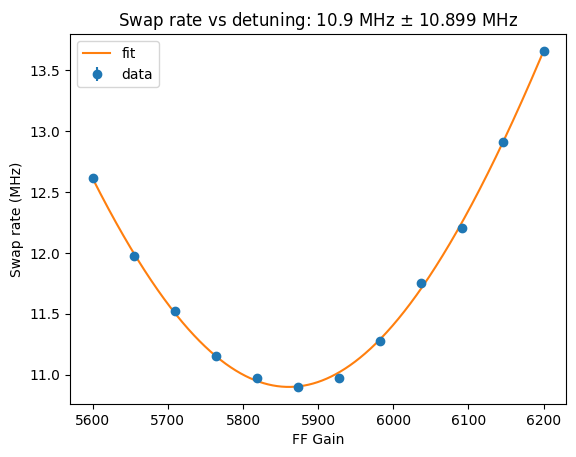

5892.444681866678


In [344]:
readout_Q2_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '02', '28', '15', '19', '44', adiabatic=True), readout_qubit='Q2')
print(readout_Q2_test_swap.get_coupling_strength())
readout_Q2_test_swap.plot_chevron_vs_gain()
readout_Q2_test_swap.plot_swap_rate_fit()
print(readout_Q3_test_swap.get_ff_gain_center())

10.819630629642809


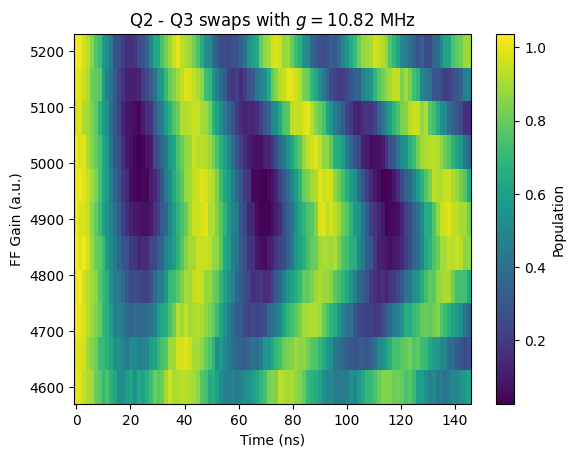

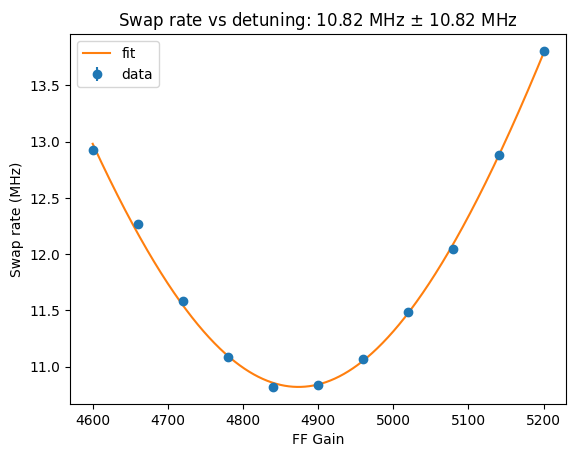

4873.772974733067


In [346]:
readout_Q2_test_swap = QubitSwapMeasurement('Q2', 'Q3', generate_swaps_filename('2025', '03', '03', '16', '50', '41', adiabatic=True), readout_qubit='Q2')
print(readout_Q2_test_swap.get_coupling_strength())
readout_Q2_test_swap.plot_chevron_vs_gain()
readout_Q2_test_swap.plot_swap_rate_fit()
print(readout_Q2_test_swap.get_ff_gain_center())

# 4. 3/5/25

9.09970966001465


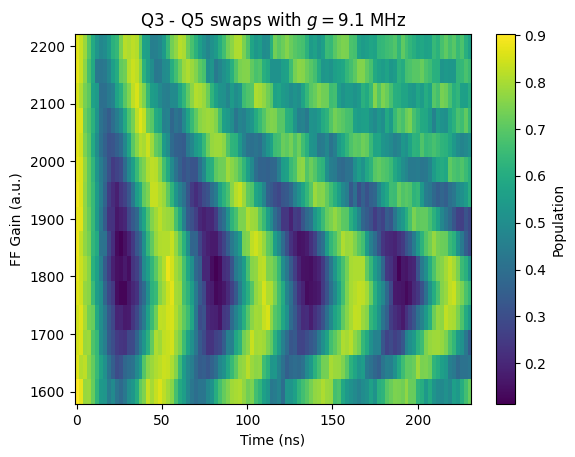

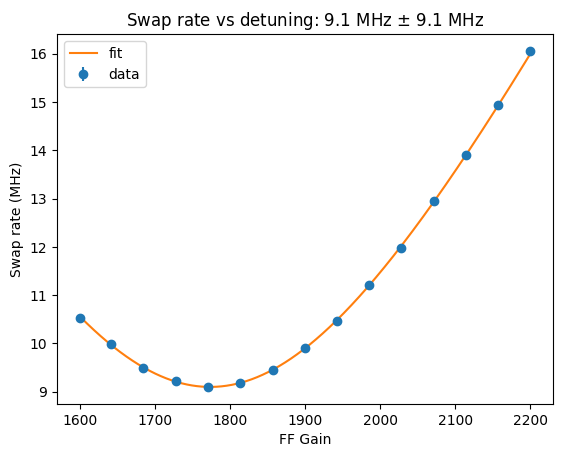

1773.795446672593


In [353]:
Q1_Q3_swap = QubitSwapMeasurement('Q3', 'Q5', generate_swaps_filename('2025', '03', '05', '13', '05', '40', adiabatic=False), readout_qubit='Q2')
print(Q1_Q3_swap.get_coupling_strength())
Q1_Q3_swap.plot_chevron_vs_gain()
Q1_Q3_swap.plot_swap_rate_fit()
print(Q1_Q3_swap.get_ff_gain_center())

9.550751441035617


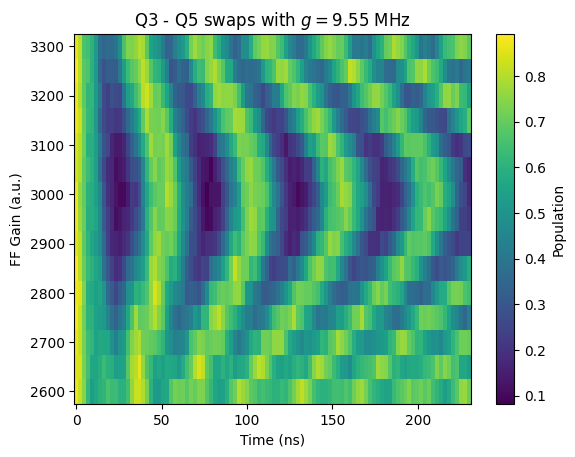

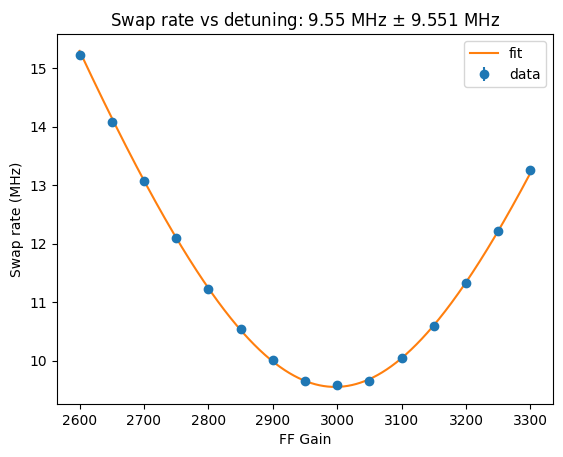

2996.822198027738


In [354]:
Q3_Q5_swap = QubitSwapMeasurement('Q3', 'Q5', generate_swaps_filename('2025', '03', '05', '12', '55', '52', adiabatic=False), readout_qubit='Q2')
print(Q3_Q5_swap.get_coupling_strength())
Q3_Q5_swap.plot_chevron_vs_gain()
Q3_Q5_swap.plot_swap_rate_fit()
print(Q3_Q5_swap.get_ff_gain_center())